In [1201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import glob
from datetime import datetime
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('mode.chained_assignment', None)

In [1103]:
#importing the data

path = 'data' 
all_files = glob.glob(path + "/*.csv")

d = {}

for i,filename in enumerate(all_files):
    d[f'{i}'] = pd.read_csv(filename, header=0)

#removing whitespaces in column names
for key, item in d.items():
    item.rename(columns=lambda x: x.strip(), inplace=True)

In [1256]:
#getting file names
file_names = [i.split('\\')[-1] for i in all_files]

In [1252]:
class Journey():
    
    def __init__(self, journey_number):
        self.journey_number = journey_number
        self.df = d[journey_number]
        
        #getting exact time from unix timestamp
        def converter(row):
            return datetime.utcfromtimestamp(row / 1000).strftime('%Y-%m-%d %H:%M:%S') 
        def hour_converter(row):
            return row[-8:]
        
        self.df['date'] = self.df['timestamp'].apply(lambda x: converter(x))
        self.df['time'] = self.df['date'].apply(lambda x: hour_converter(x))
        
        #dropping duplicates if any
        self.df = self.df.drop_duplicates()
    
    #descriptive statistics about data
    def description(self):
        gps = self.df[self.df['type'] == 'gps'].drop(['x','y','z','timestamp'],axis=1)
        acc = self.df[self.df['type']=='accelerometer'].drop(['lat','lon','height','timestamp','speed','bearing', 'accuracy'], axis=1)
        
        print('Descriptive Stats for:',self.journey_number)
        print(gps.isna().sum(),'\n', gps.describe())
        print(acc.isna().sum(), '\n',acc.describe())
        
    #Distribution plots for numeric values
    def dist_plot(self):
        
        data = self.df[['speed','accuracy','bearing','x','y','z']]
        data.hist( bins=25, layout=(3,3), figsize=(15, 8), label='Histograms for' + self.journey_number) 
        plt.show()

        
        
    #drawing lineplot of speed varible
    def speed_graph(self):

        gps = self.df[self.df['type'] == 'gps']

        plt.figure(figsize=(12,8))

        ax = sns.lineplot(x='time', y='speed', data=gps)
        plt.xlabel('Time', fontsize=15)
        plt.ylabel('Speed', fontsize=15)
        ax.set(xticks=gps['time'][0::(len(self.df) // 100)])
        plt.xticks(rotation=12, fontsize=10)
        plt.show()
        

    #drawing accelerometer value
    def acc_graph(self):
        acc = self.df[self.df['type'] == 'accelerometer']
        acc_melted = pd.melt(acc[['time','x','y','z',]],id_vars='time')
        
        plt.figure(figsize=(12,8))
        
        ax = sns.lineplot(x='time', y='value', hue='variable', 
                     data=acc_melted)

        plt.title('Accelerometer Values', fontsize=15)
        plt.xlabel('Time', fontsize=15)
        plt.ylabel('G', fontsize=15)
        plt.xticks(rotation=12, fontsize=10)
        plt.yticks(fontsize=12)
        ax.set(xticks=acc['time'][0::(len(acc) // 10)])
        plt.xticks(rotation=12, fontsize=10)
        plt.legend(loc='best')
        plt.show()
            
    #speed vs accelerometer data
    #accelerometer data is measued in miliseconds whereas gps data is in seconds. Hence, I calculated average G for each second.
    #Then merged dataframes
    def speed_acc(self):
        
        gps_data = self.df[self.df['type']=='gps'].drop(['x','y','z'],axis=1)
        grouped_acc_data = self.df[self.df['type']=='accelerometer'].groupby('time')[['x','y','z']].mean().reset_index()
        merged_data= pd.merge(gps_data, grouped_acc_data, on='time') 
  
        ax = merged_data.plot(x="time", y="speed", figsize=(12,8), label='Speed',fontsize=15)
        ax2 = ax.twinx()
        merged_data.plot(x="time", y="x", ax=ax2, legend=False, color="r", label='X',fontsize=15)
        merged_data.plot(x="time", y="y", ax=ax2, legend=False, color="y", label='Y')
        merged_data.plot(x="time", y="z", ax=ax2, legend=False, color="g", label='Z')
        
        ax.set_xlabel("Time", fontsize=15)
        ax.set_ylabel("Speed", fontsize=15)
        ax2.set_ylabel("G", fontsize=15)


        ax2.legend(loc='best', prop={'size': 15})
        ax.legend(loc='upper left', prop={'size': 15})
        plt.show()
    
    #The method for anomaly detection.
    def anomaly(self):
        
        #first, calculate PCA
        pca = PCA(n_components=1)
        pc = pca.fit_transform(self.df[['x','y','z']].dropna())
        
        #add principal component to accelerometer data.
        acc = self.df[self.df['type']=='accelerometer']
        acc['pc'] = pc
        
        #getting maximum scalar value here.
        acc_abs = acc.copy()
        acc_abs['pc'] = acc_abs['pc'].abs()
        idx = acc_abs.groupby('time')['pc'].idxmax()
        acc= acc.loc[idx.values]
        
        gps_data = self.df[self.df['type']=='gps']
        
        
        # outlier_lower = Q1 - (1.5*IQR)
        # outlier_upper = Q3 + (1.5*IQR)
        #IQR = Q3 - Q1
        q1, q3 = acc['pc'].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - (1.5*iqr)
        upper = q3 + (1.5*iqr)
        
        
        #adding labels to data
        acc['anomaly'] = 0
        acc.loc[((acc['pc']>upper) | (acc['pc']<lower)), 'anomaly'] = 1
        
        # Let's plot the outliers from pc 
        a = acc[acc['anomaly'] == 1] #anomaly
        
        print('possible accident time for journey:', self.journey_number, a['time'].values)
        
        fig,ax =plt.subplots(figsize=(18,5))
        
        ax.plot(acc['time'],acc['pc'], color='blue', label='Normal')
        ax.plot(a['time'],a['pc'], linestyle='none', marker='.', color='red', markersize=10, label='Anomaly')
        ax.set(xticks=acc['time'][0::(len(acc) // 10)])
        ax.legend(loc='best', fontsize=12)
        ax.set_ylabel("G", fontsize=15)
        
        fig2,ax2 =plt.subplots(figsize=(18,5))
        ax2.plot(gps_data['time'],gps_data['speed'], color='blue', label='Speed')
        ax2.set(xticks=gps_data['time'][0::(len(gps_data) // 11)])
        ax2.set_ylabel("Speed", fontsize=15)
        ax2.legend()
                
        plt.show()
        
        


    

In [1232]:
#description of each journey
for i in d.keys():
    x = Journey(i)
    x.description()
    print('\n\n')

Descriptive Stats for: 0
type        0
lat         0
lon         0
height      0
accuracy    0
speed       0
bearing     0
date        0
time        0
dtype: int64 
           lat     lon  height  accuracy   speed  bearing
count 401.000 401.000 401.000   401.000 401.000  401.000
mean   44.775 -85.376 208.144     5.000   5.093  170.015
std     0.001   0.003   8.742     0.000   6.337  104.312
min    44.773 -85.384 197.145     5.000   0.000   -1.000
25%    44.774 -85.374 203.639     5.000   0.000   88.242
50%    44.775 -85.374 204.399     5.000   0.670  179.648
75%    44.775 -85.374 206.203     5.000  10.780  226.758
max    44.778 -85.372 231.121     5.000  18.080  354.727
type    0
x       0
y       0
z       0
date    0
time    0
dtype: int64 
              x        y        z
count 4025.000 4025.000 4025.000
mean    -0.365   -0.779   -0.141
std      0.146    0.161    0.444
min     -1.195   -1.544   -1.774
25%     -0.467   -0.910   -0.574
50%     -0.371   -0.802    0.020
75%     -0.288 

Descriptive Stats for: 8
type        0
lat         0
lon         0
height      0
accuracy    0
speed       0
bearing     0
date        0
time        0
dtype: int64 
            lat      lon   height  accuracy    speed  bearing
count 1114.000 1114.000 1114.000  1114.000 1114.000 1114.000
mean    42.521  -83.040  190.162    10.000    8.211  132.526
std      0.018    0.008    2.964     7.361    8.664   98.118
min     42.507  -83.051  180.064     5.000    0.000   -1.000
25%     42.509  -83.048  188.422     5.000    0.000   43.242
50%     42.510  -83.044  189.961    10.000    5.830  173.496
75%     42.529  -83.032  193.169    10.000   15.660  178.594
max     42.564  -83.031  195.893    50.000   50.300  359.648
type    0
x       0
y       0
z       0
date    0
time    0
dtype: int64 
               x         y         z
count 11139.000 11139.000 11139.000
mean     -0.181    -0.585    -0.425
std       0.397     0.474     0.314
min      -4.013    -6.896    -2.449
25%      -0.091    -0.940    -

Descriptive Stats for: 16
type        0
lat         0
lon         0
height      0
accuracy    0
speed       0
bearing     0
date        0
time        0
dtype: int64 
           lat     lon  height  accuracy   speed  bearing
count 681.000 681.000 681.000   681.000 681.000  681.000
mean   41.872 -87.819 187.040     6.564   6.403  200.093
std     0.001   0.017   7.676     2.473   7.243  135.702
min    41.868 -87.839 175.157     5.000   0.000   -1.000
25%    41.871 -87.839 177.215     5.000   0.000   -1.000
50%    41.872 -87.815 188.504     5.000   4.370  268.594
75%    41.873 -87.804 193.654    10.000  10.690  277.031
max    41.874 -87.794 197.808    30.000  26.580  359.648
type    0
x       0
y       0
z       0
date    0
time    0
dtype: int64 
              x        y        z
count 6797.000 6797.000 6797.000
mean     0.088   -0.055    0.980
std      0.227    0.117    0.210
min     -3.165   -3.349   -4.100
25%      0.056   -0.087    0.986
50%      0.058   -0.039    1.000
75%      0.115

Descriptive Stats for: 24
type        0
lat         0
lon         0
height      0
accuracy    0
speed       0
bearing     0
date        0
time        0
dtype: int64 
            lat      lon   height  accuracy    speed  bearing
count 1080.000 1080.000 1080.000  1080.000 1080.000 1080.000
mean    41.968  -87.789  189.005    18.708   12.542  126.840
std      0.019    0.060    6.474    15.378    9.286   68.283
min     41.931  -87.893  176.918     5.000    0.000    2.109
25%     41.954  -87.839  183.076    10.000    1.470   87.188
50%     41.978  -87.789  189.642    10.000   14.305  107.754
75%     41.983  -87.732  195.188    30.000   21.737  130.781
max     41.985  -87.710  199.853    50.000   27.850  352.266
type    0
x       0
y       0
z       0
date    0
time    0
dtype: int64 
               x         y         z
count 17111.000 17111.000 17111.000
mean      0.185    -0.001    -0.601
std       0.609     0.461     0.312
min      -2.275    -1.880    -2.502
25%      -0.079    -0.319    

0


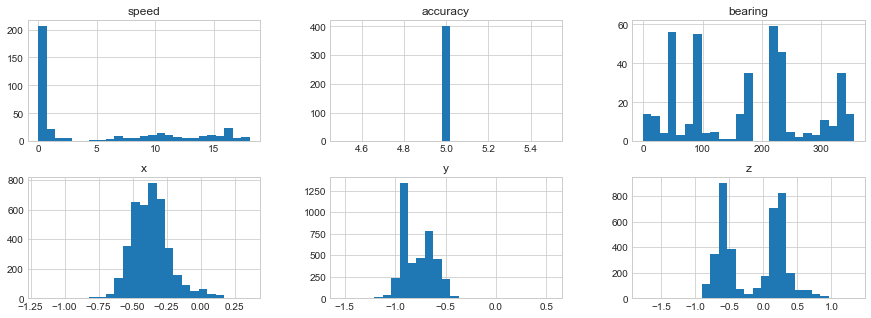

1


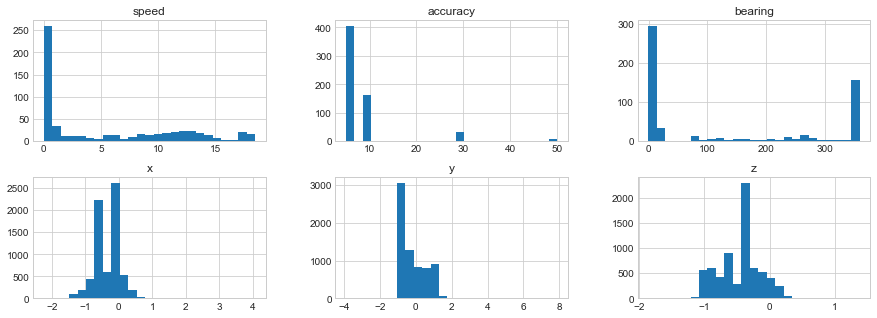

2


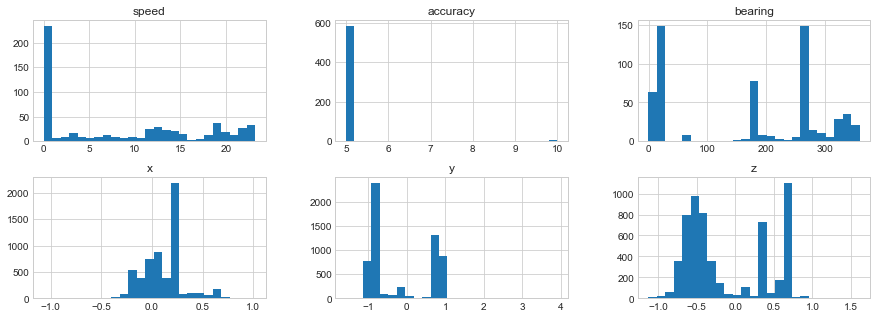

3


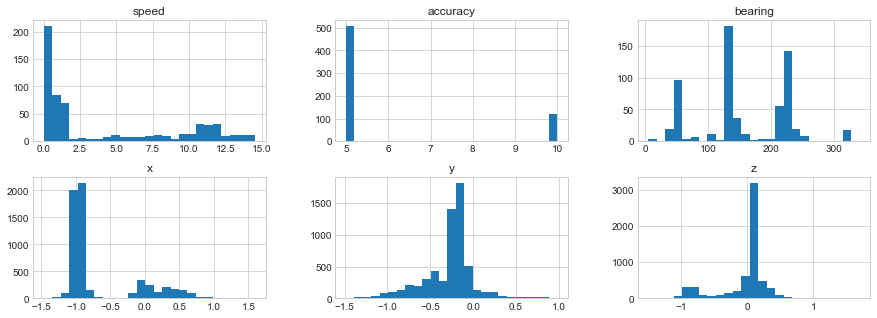

4


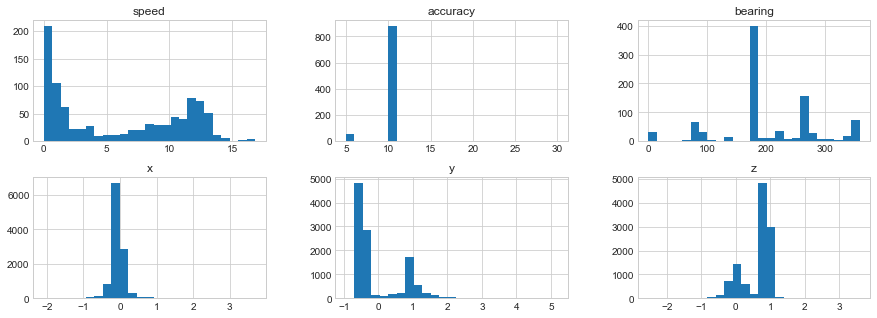

5


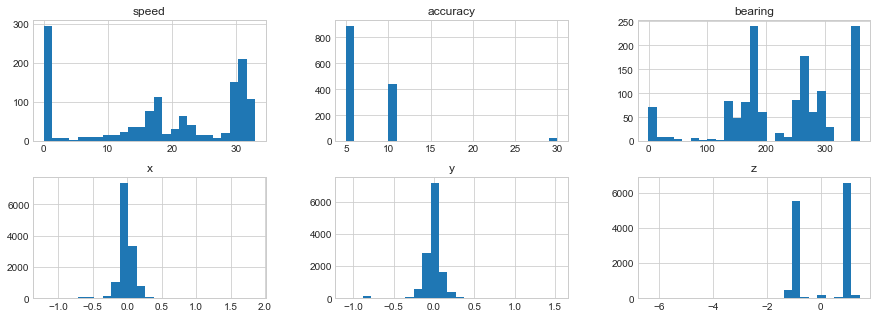

6


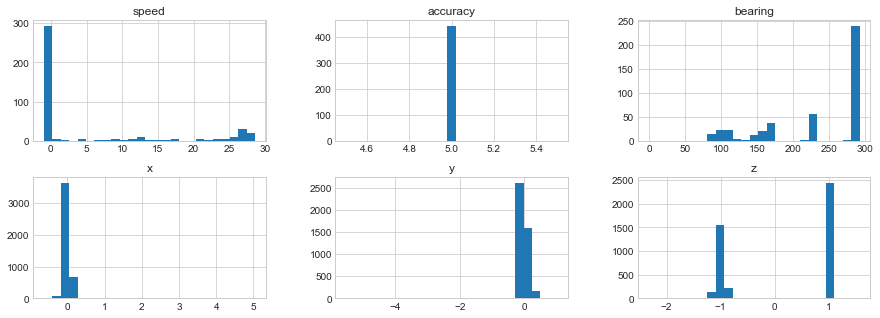

7


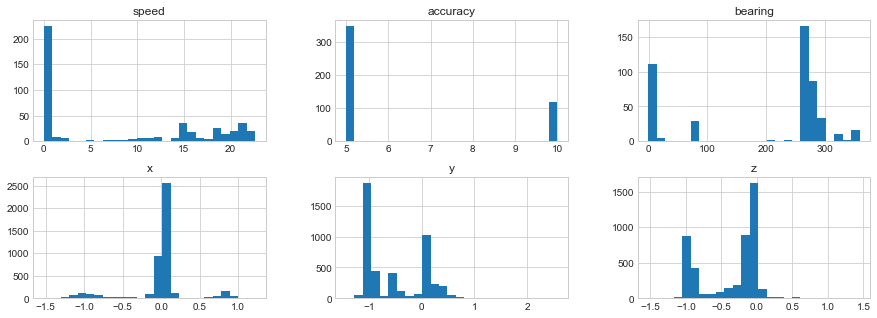

8


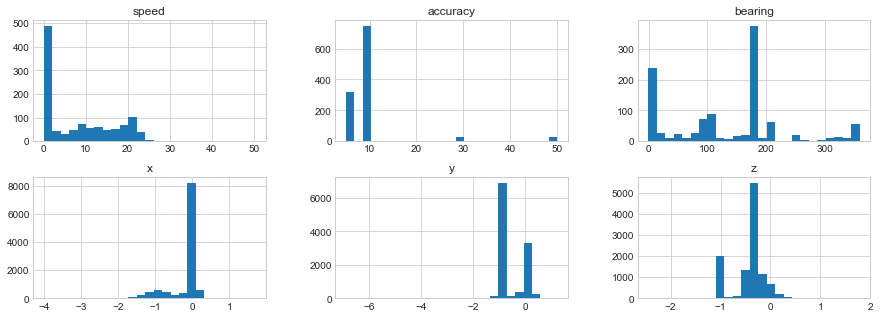

9


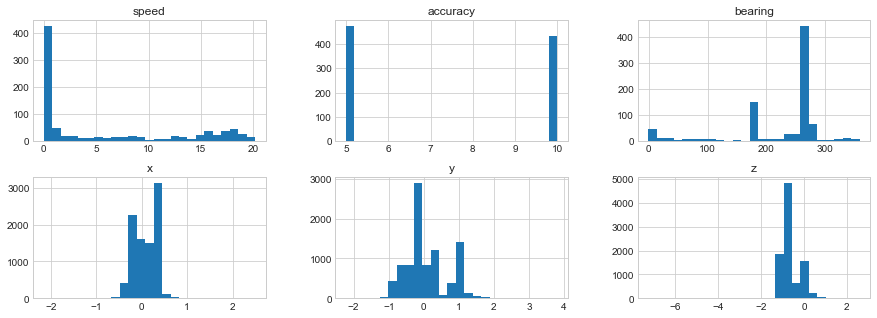

10


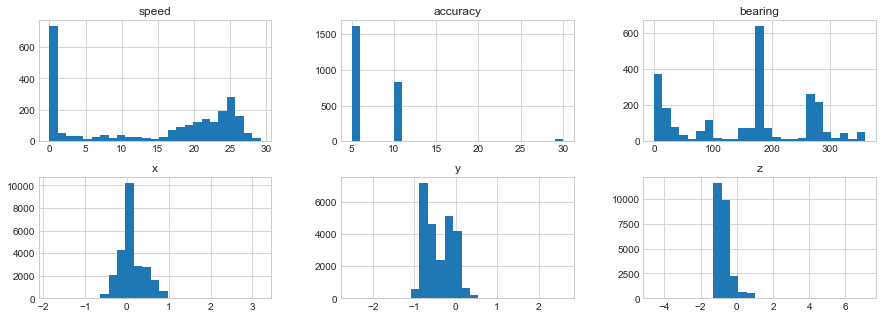

11


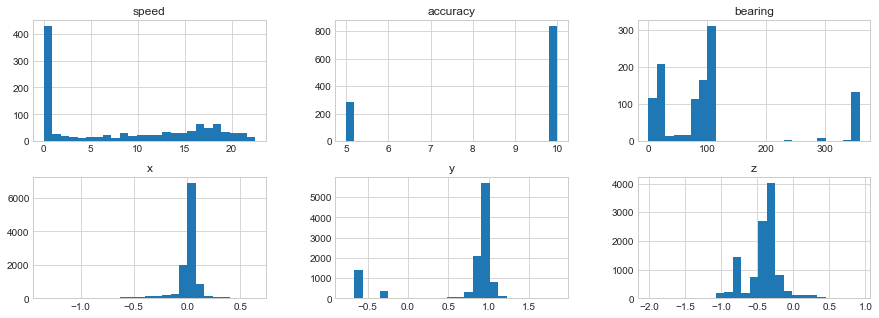

12


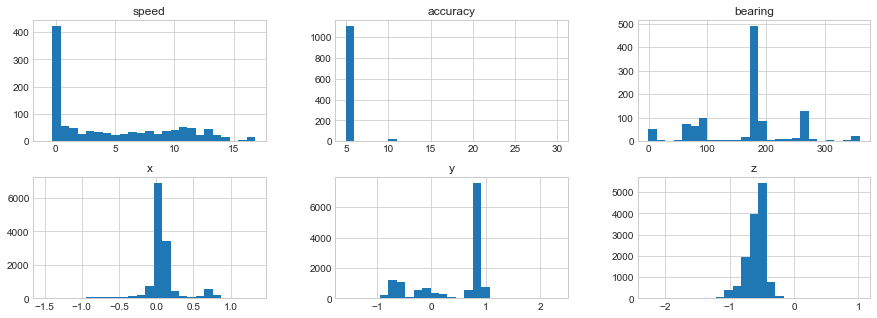

13


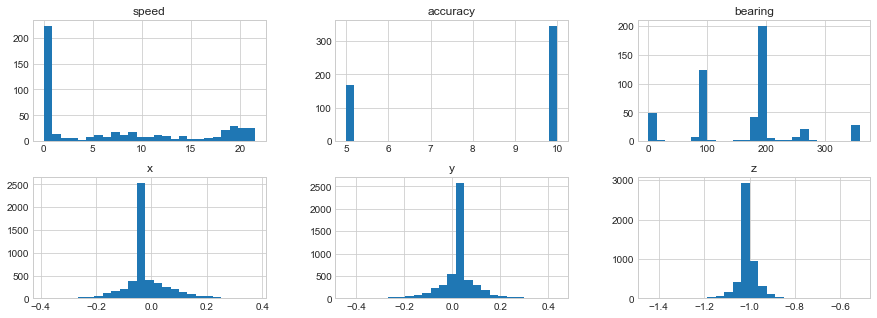

14


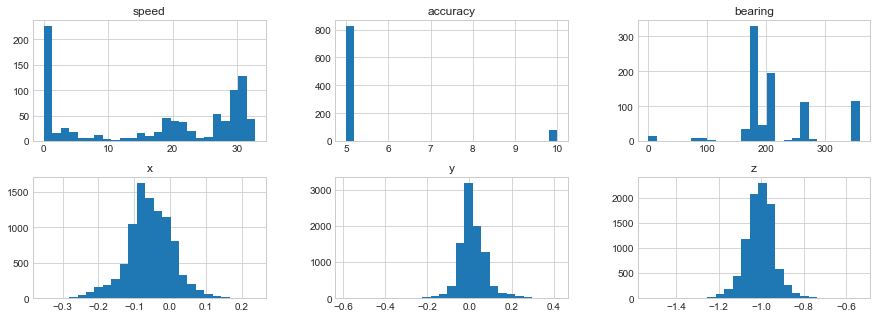

15


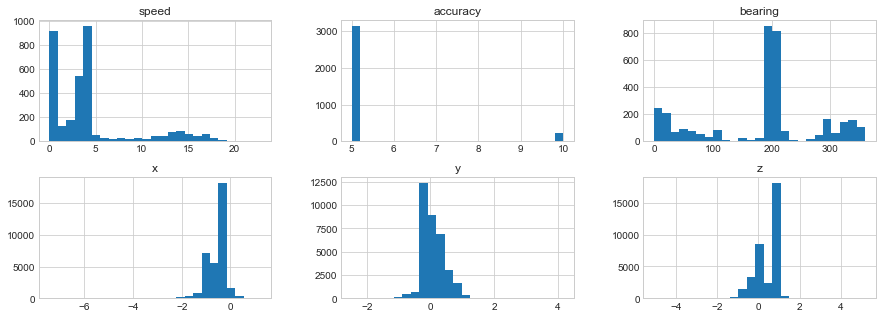

16


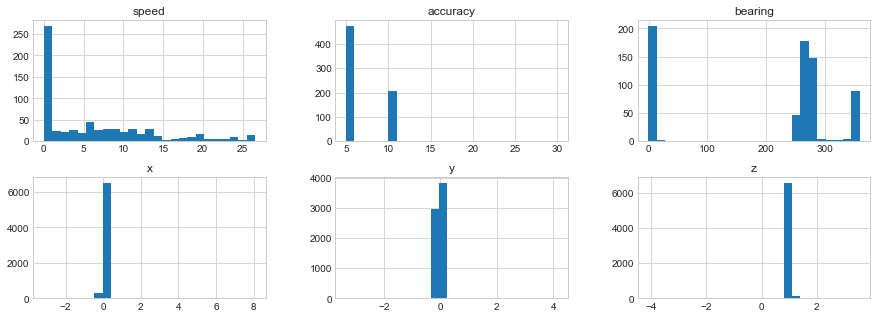

17


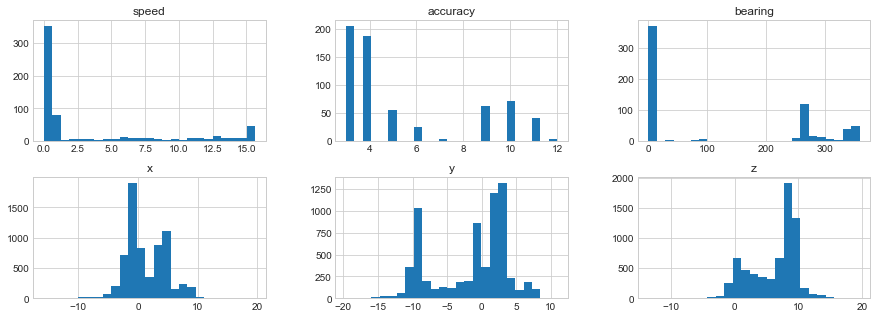

18


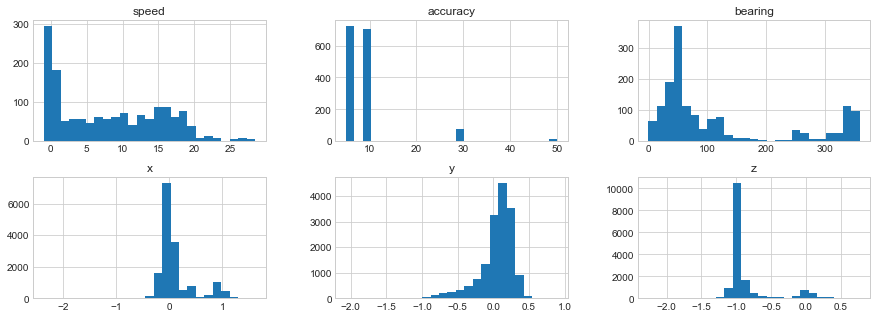

19


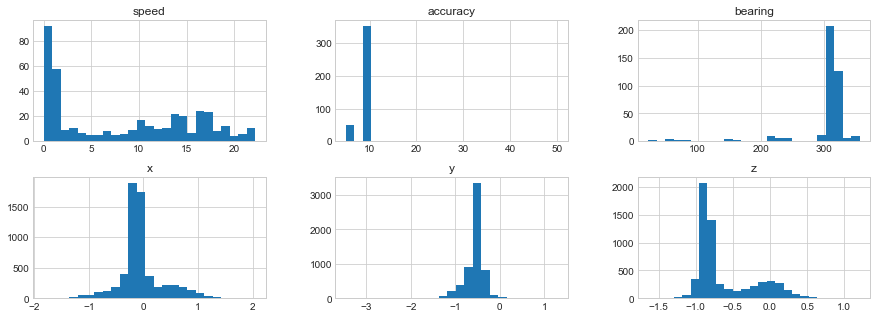

20


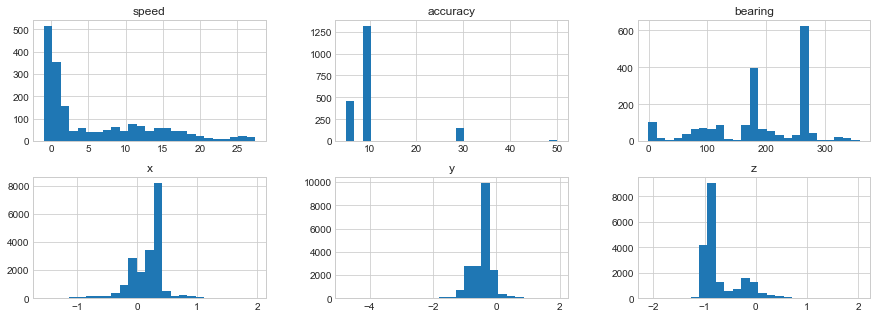

21


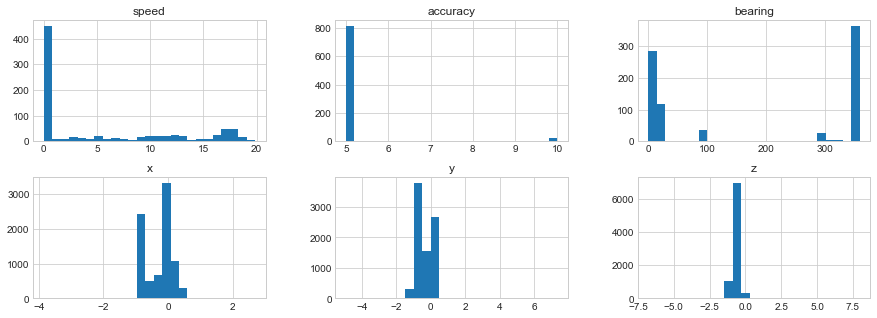

22


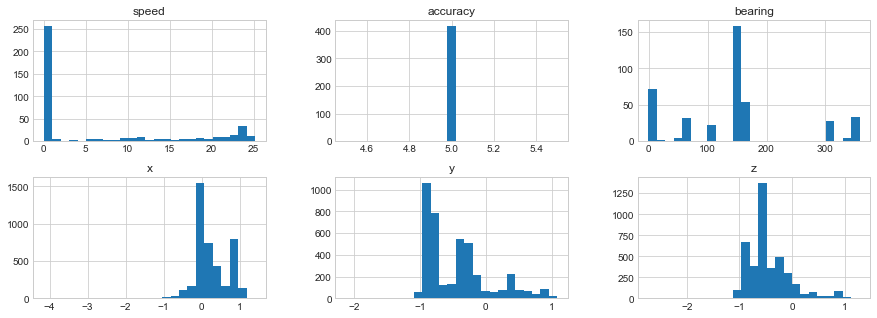

23


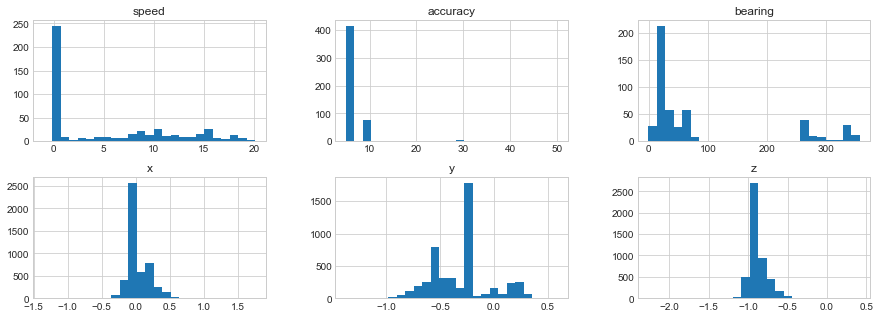

24


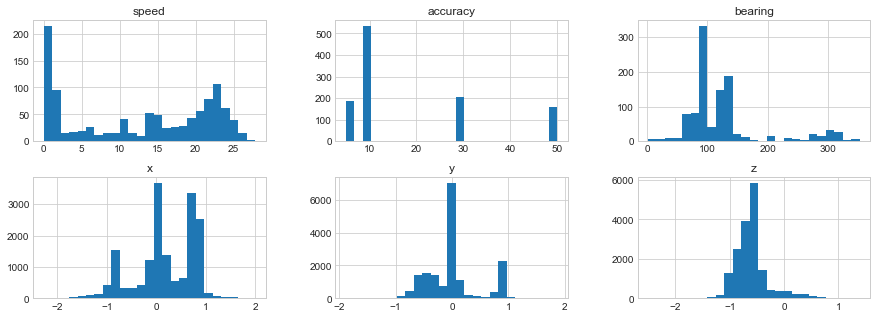

In [1248]:
#Distribution plots of each journey
for i in d.keys():
    print(i)
    x = Journey(i)
    x.dist_plot()

0


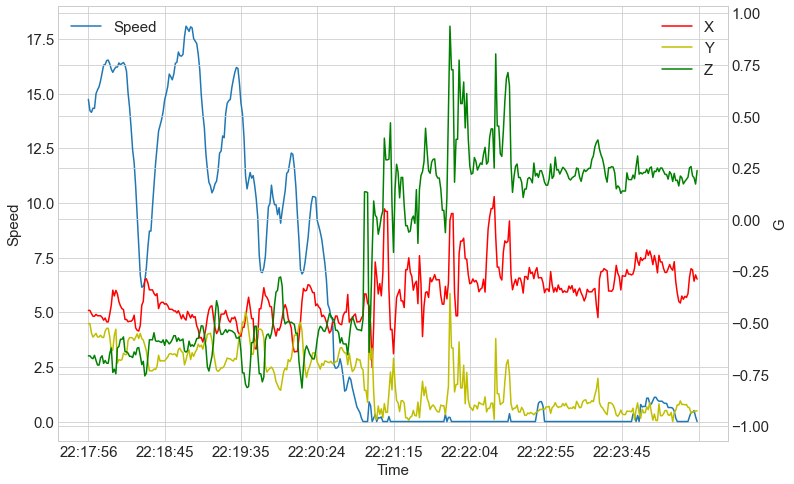

None
1


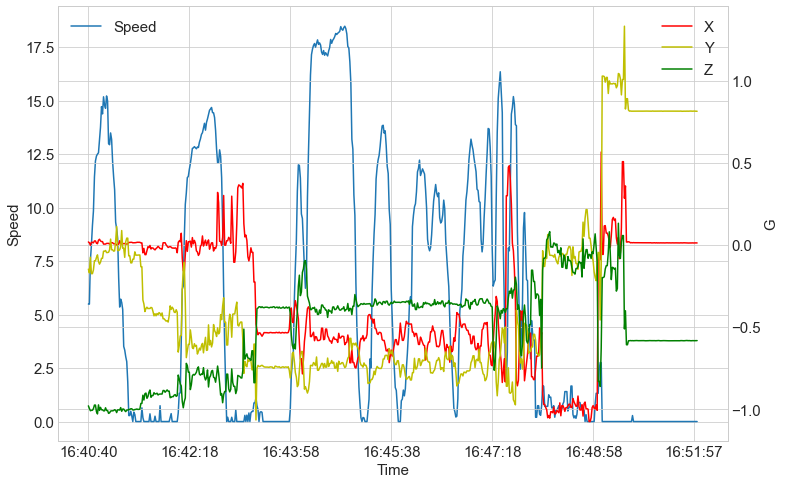

None
2


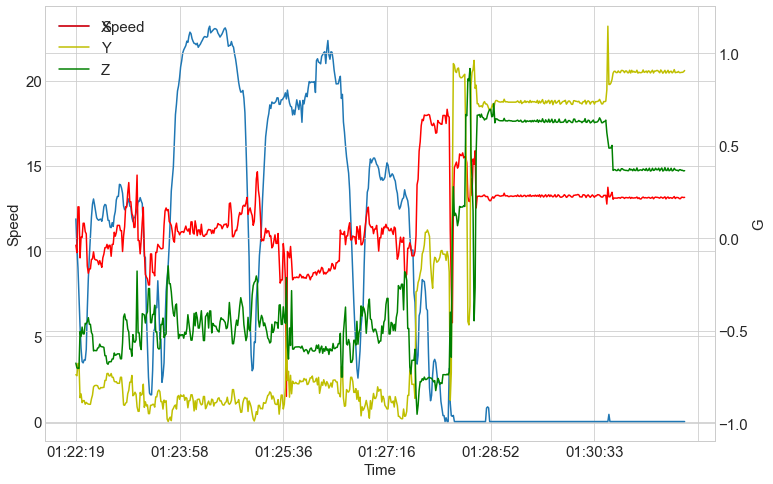

None
3


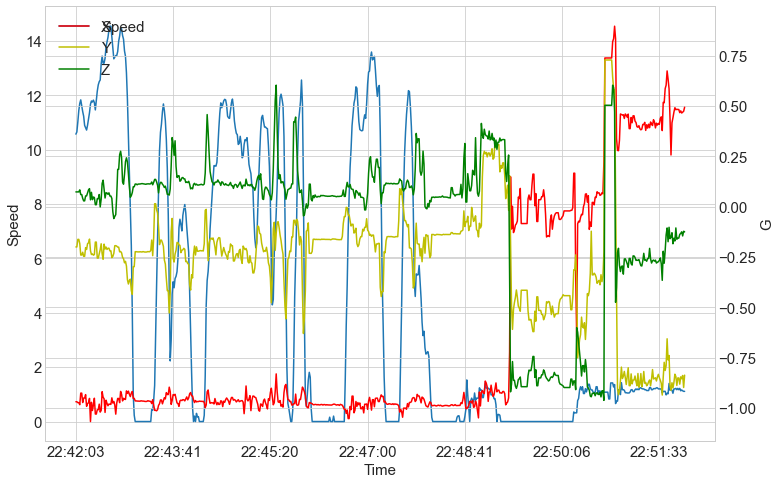

None
4


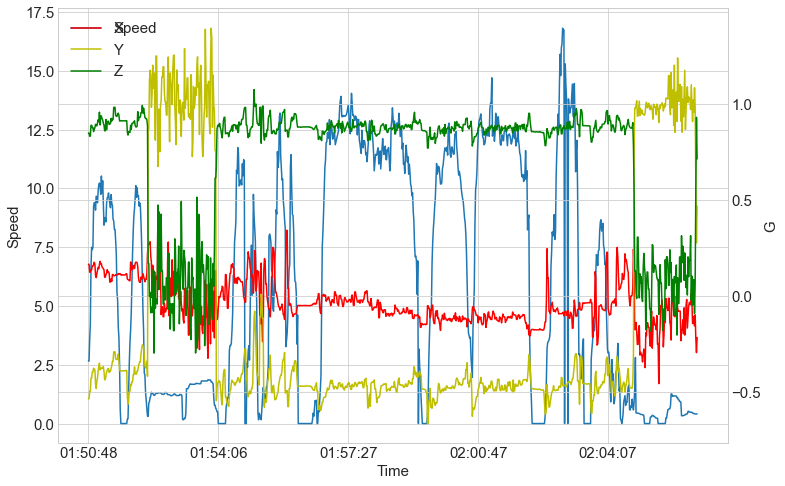

None
5


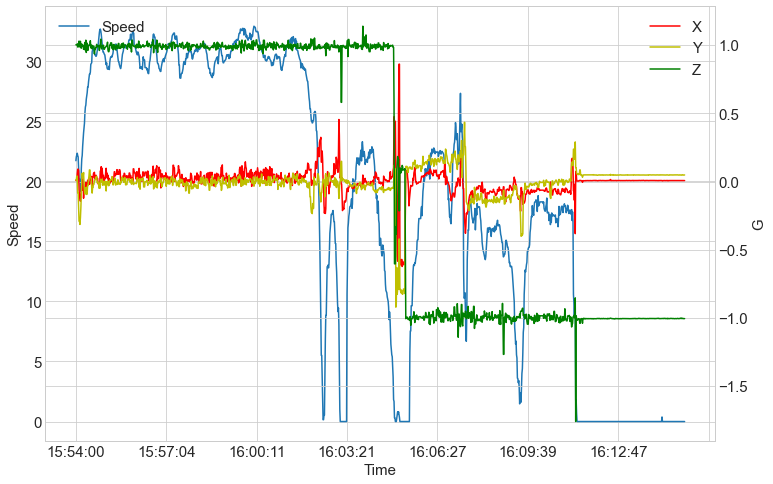

None
6


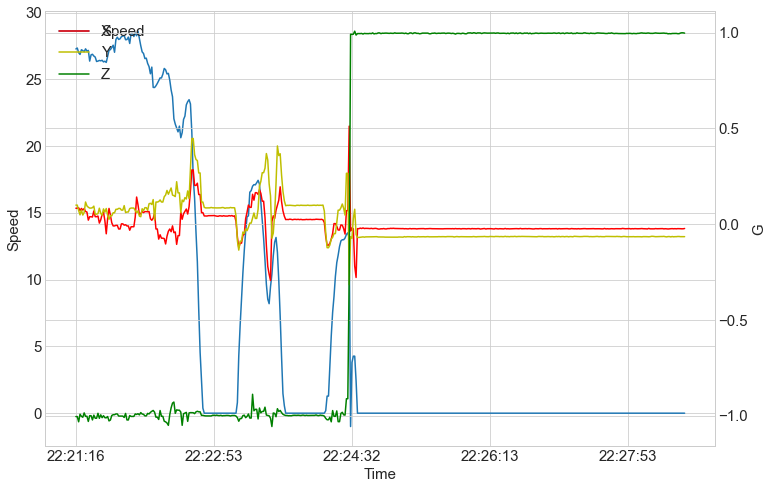

None
7


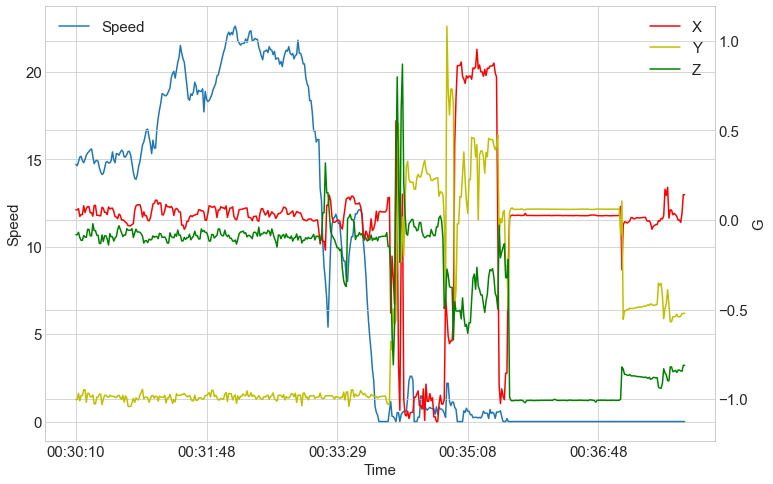

None
8


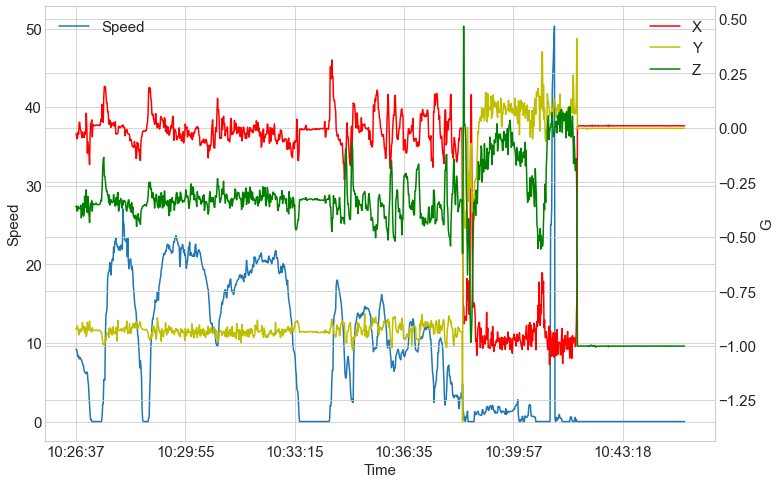

None
9


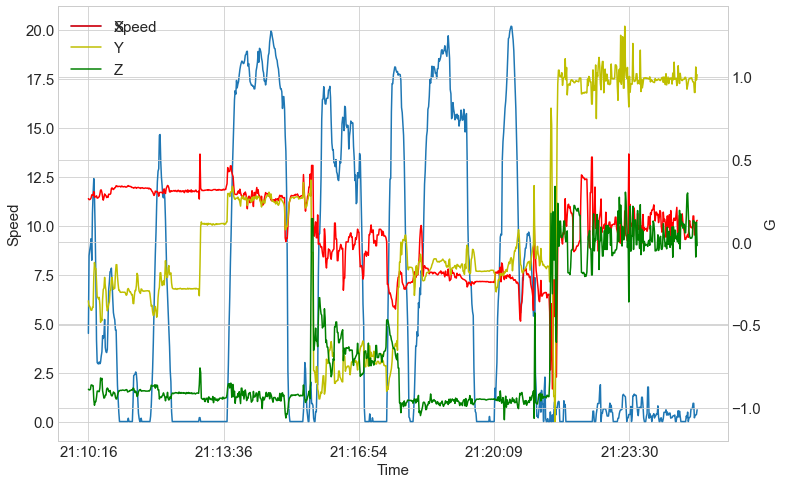

None
10


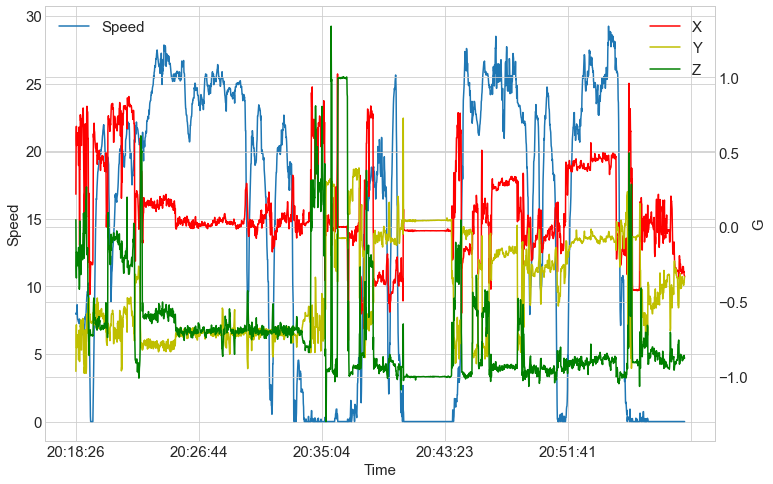

None
11


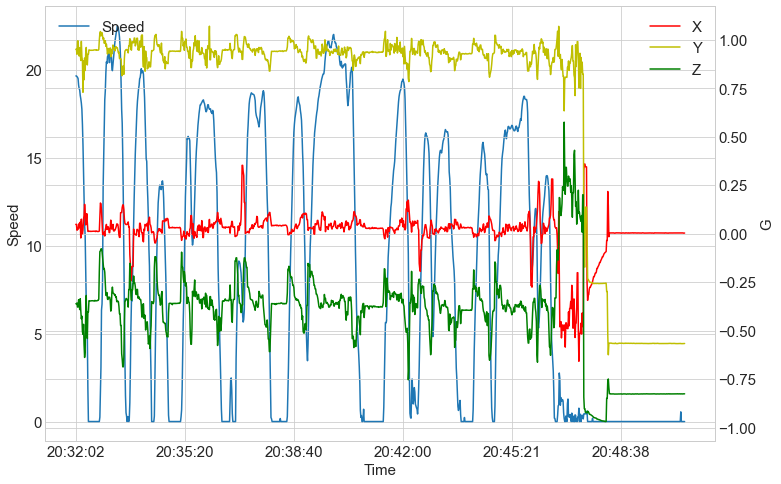

None
12


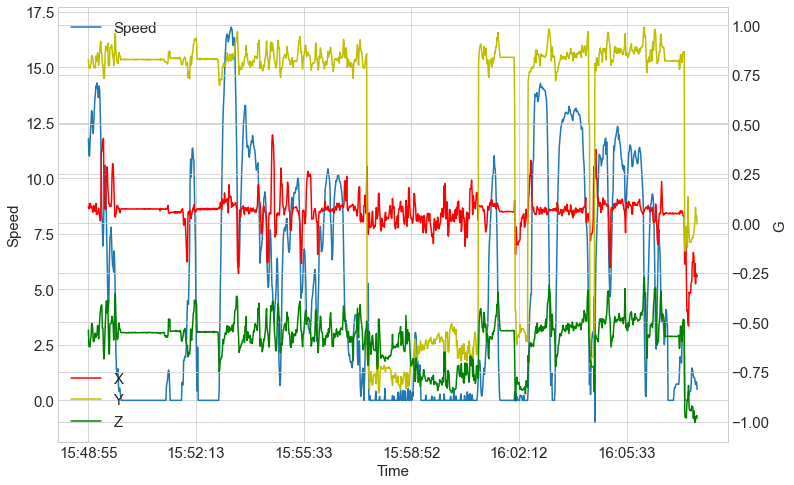

None
13


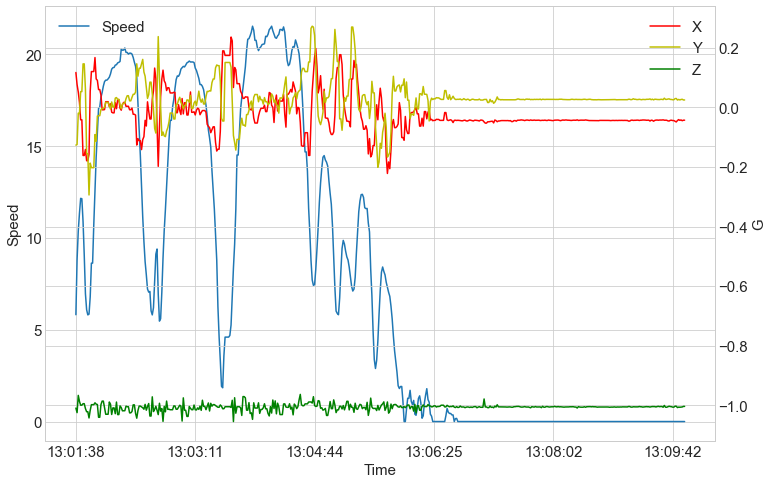

None
14


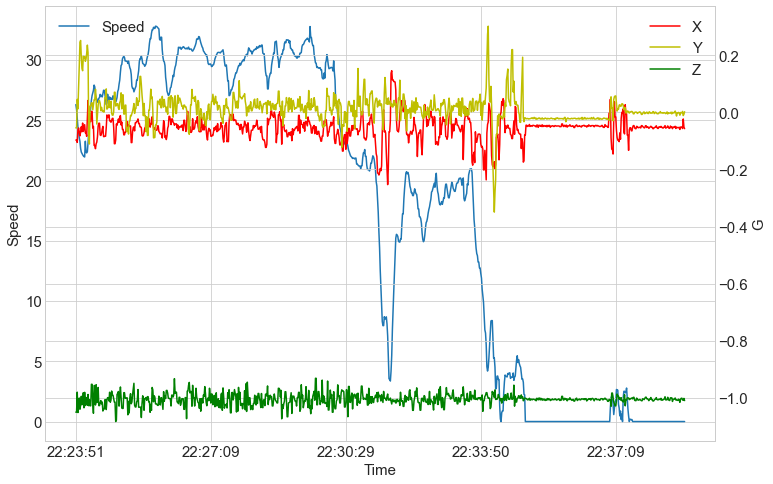

None
15


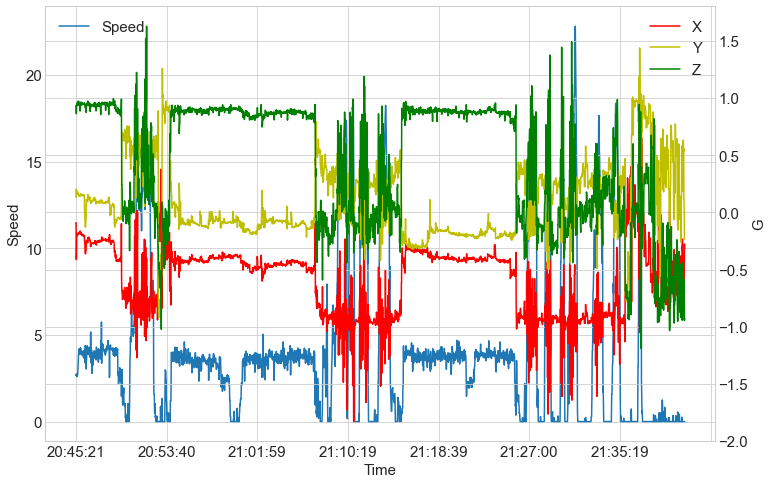

None
16


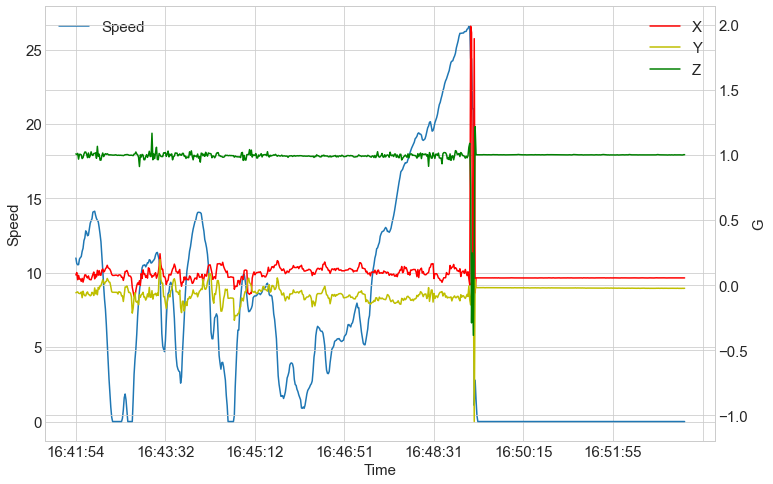

None
17


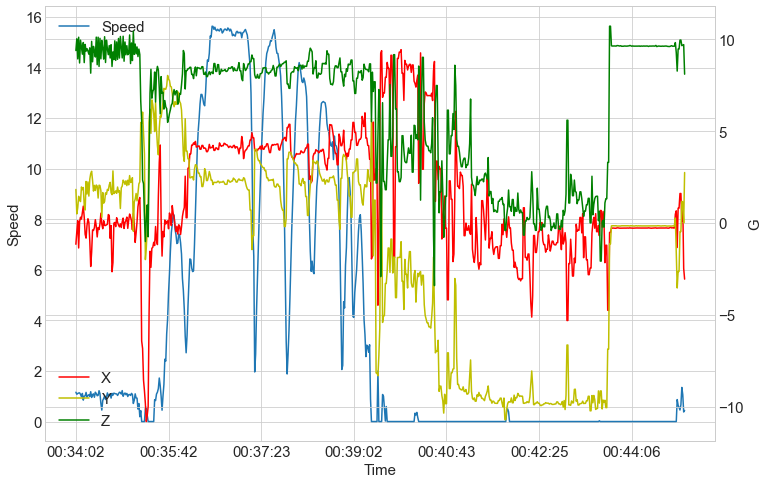

None
18


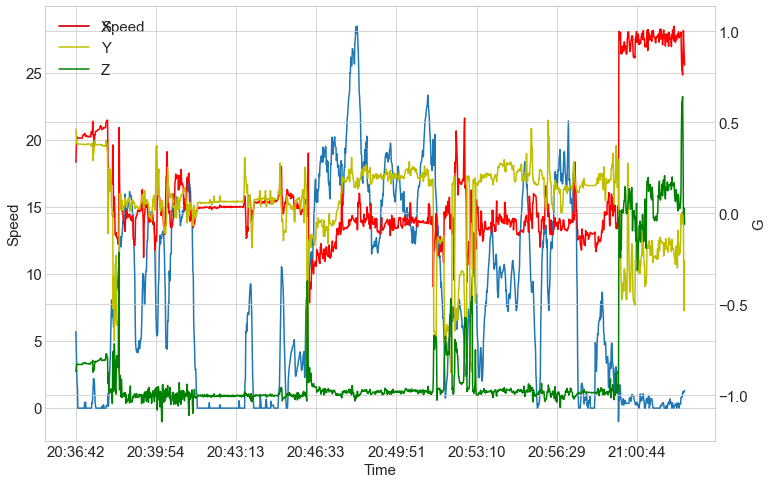

None
19


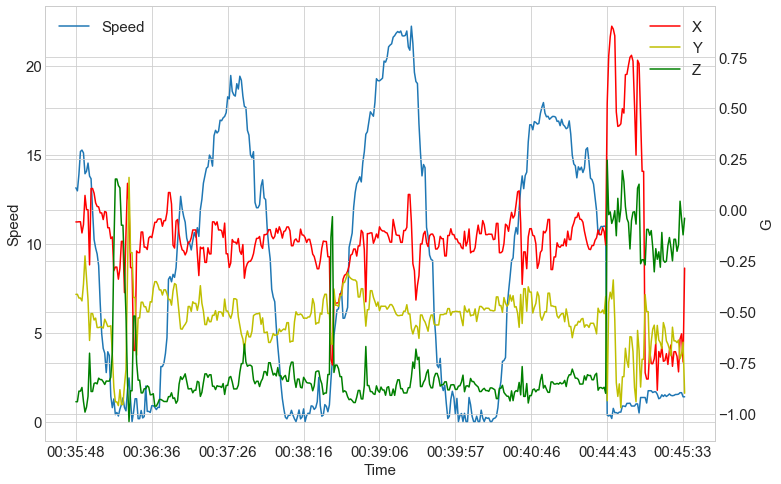

None
20


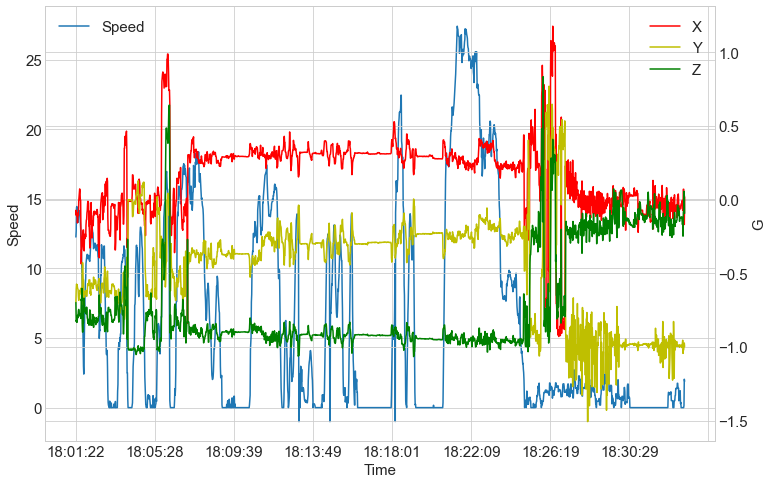

None
21


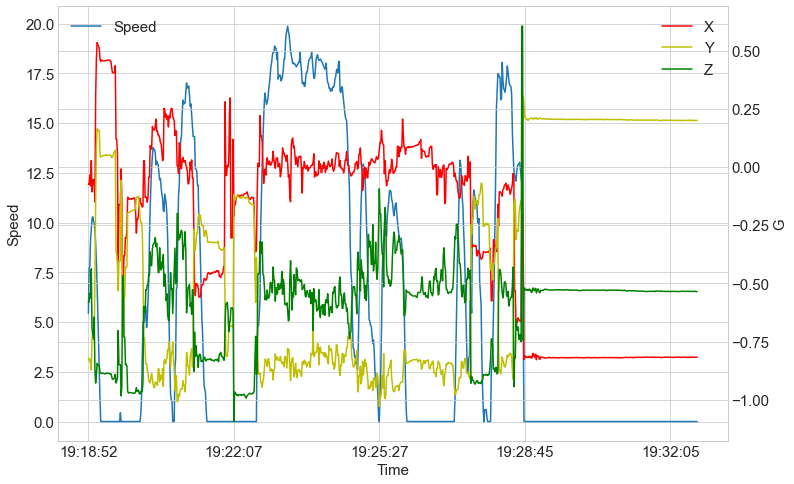

None
22


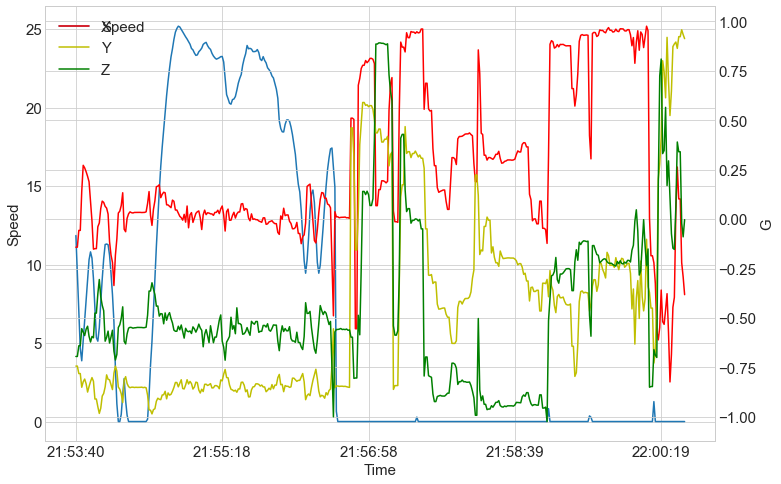

None
23


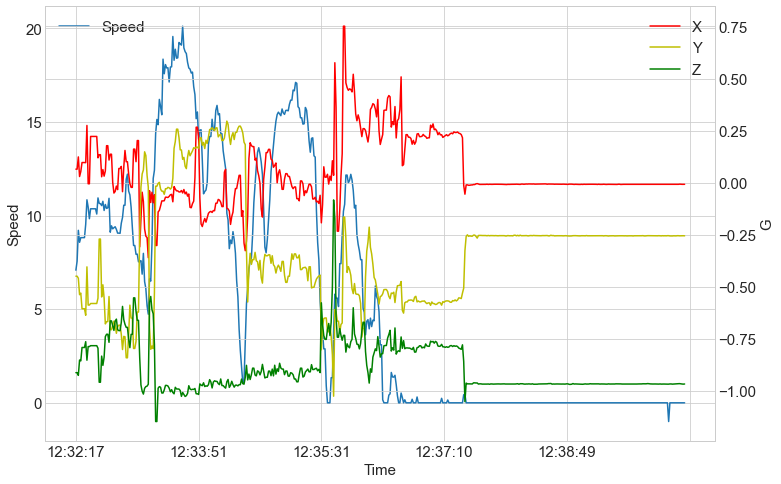

None
24


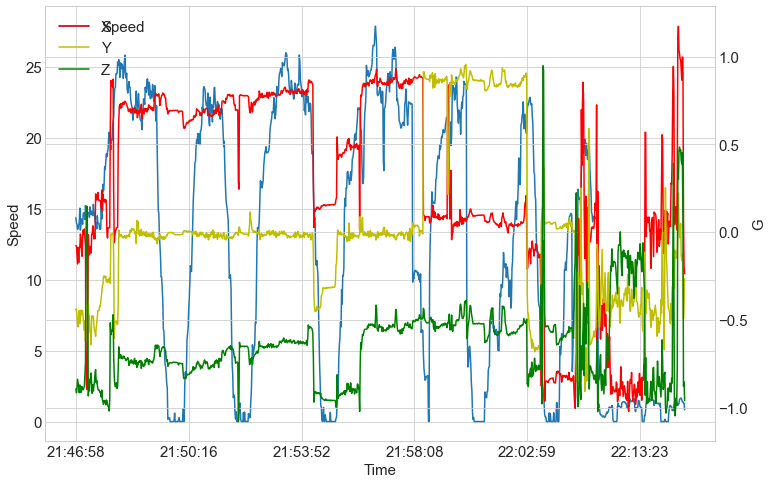

None


In [1253]:
#plots 
for i in d.keys():
    print(i)
    x = Journey(i)
    print(x.speed_acc())

The journey Id is: 00DAC437-FF8B-4DA3-9E24-4EE1B1AA12EC.csv
possible accident time for journey: 0 []


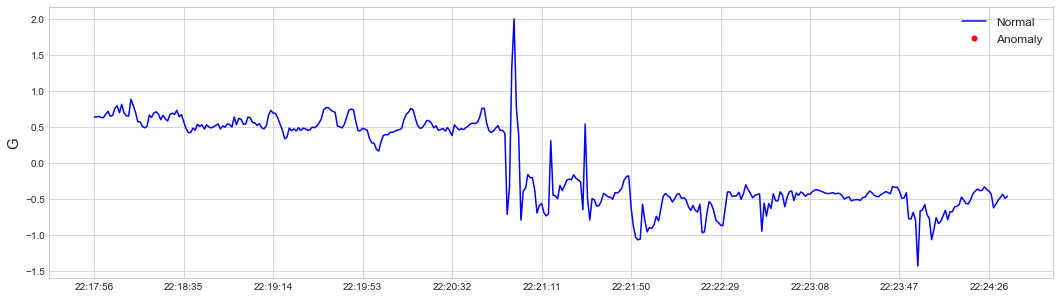

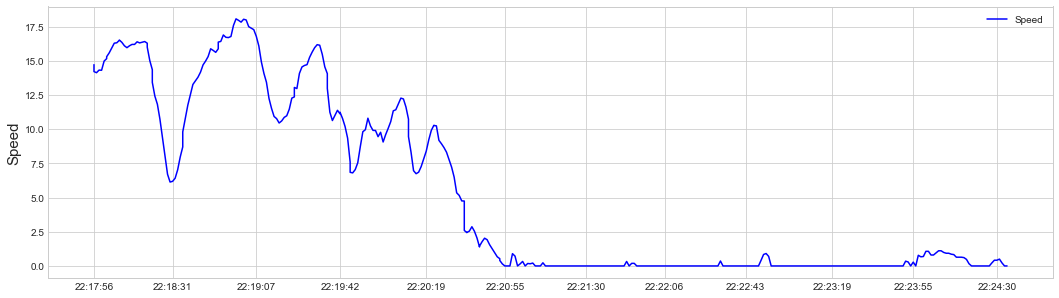

None
The journey Id is: 05A03532-5BE9-4749-9460-CCCEADA6C786.csv
possible accident time for journey: 1 ['16:43:24' '16:50:48']


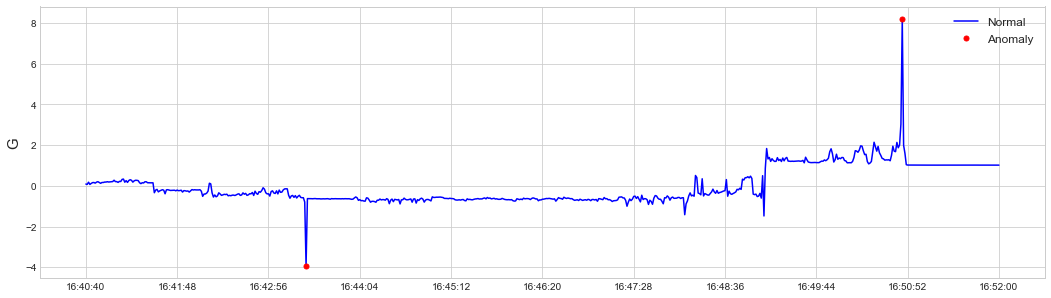

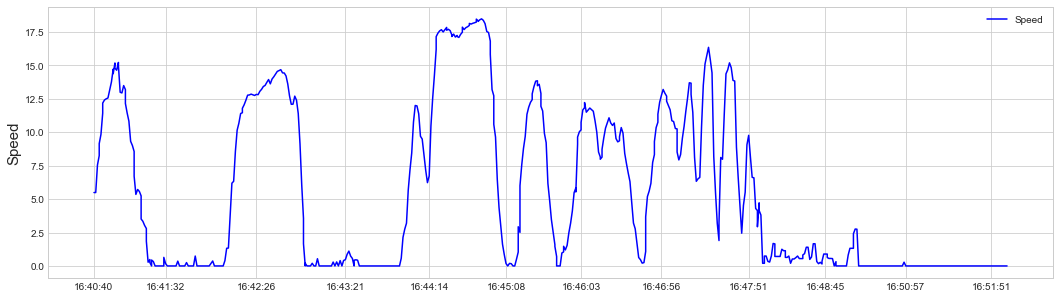

None
The journey Id is: 18E4E1E7-D48D-4D39-B92B-ACB831E2F530.csv
possible accident time for journey: 2 ['01:30:45']


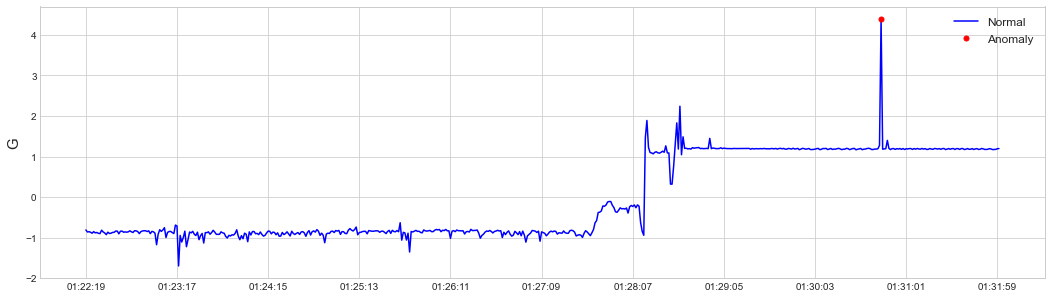

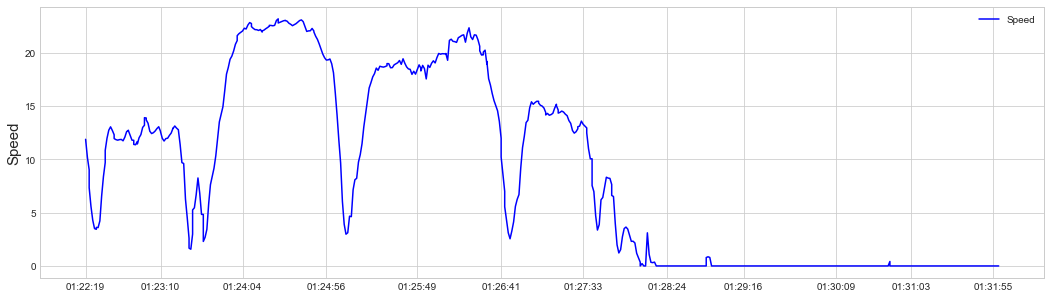

None
The journey Id is: 1A9494FB-DF91-45FD-B8DD-43B64A8A9ED9.csv
possible accident time for journey: 3 []


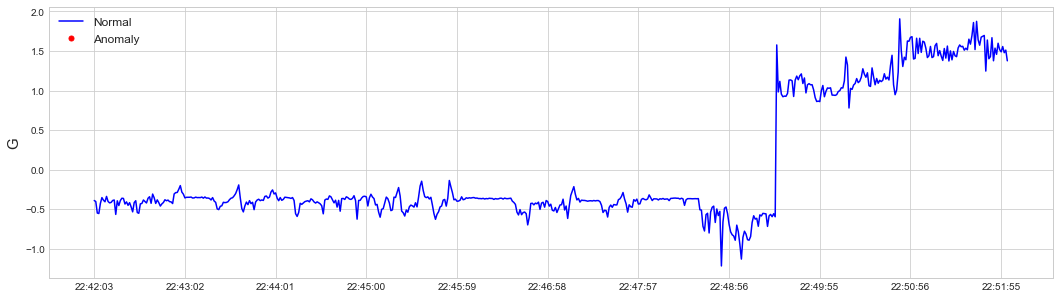

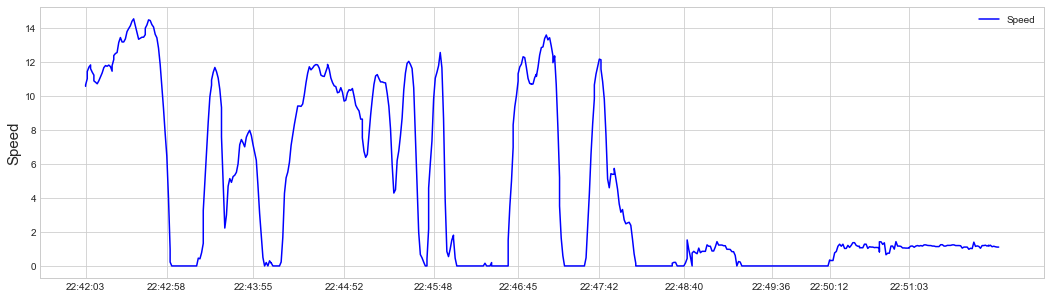

None
The journey Id is: 268A6026-853A-4E84-9D12-4DBDE18EBE41.csv
possible accident time for journey: 4 []


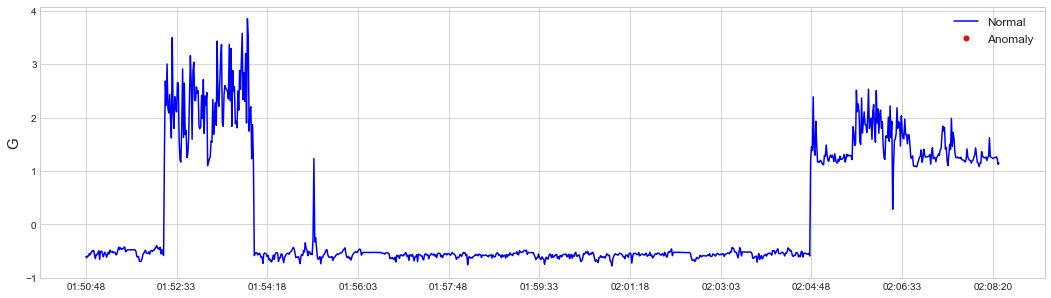

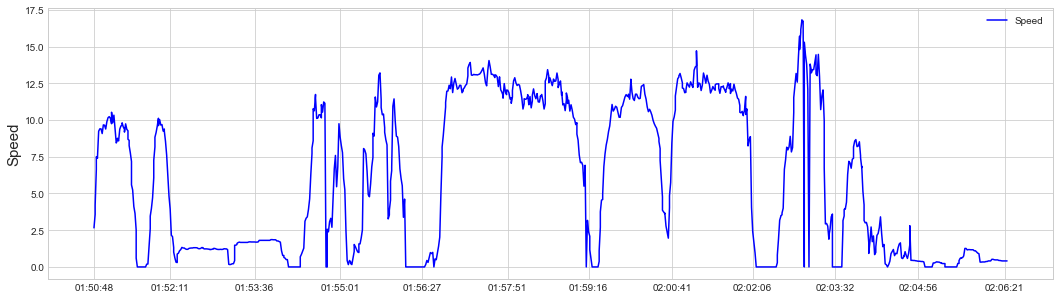

None
The journey Id is: 2D81A857-FE87-4775-85AD-9ADFAEDDDFCF.csv
possible accident time for journey: 5 ['16:09:29' '16:11:14']


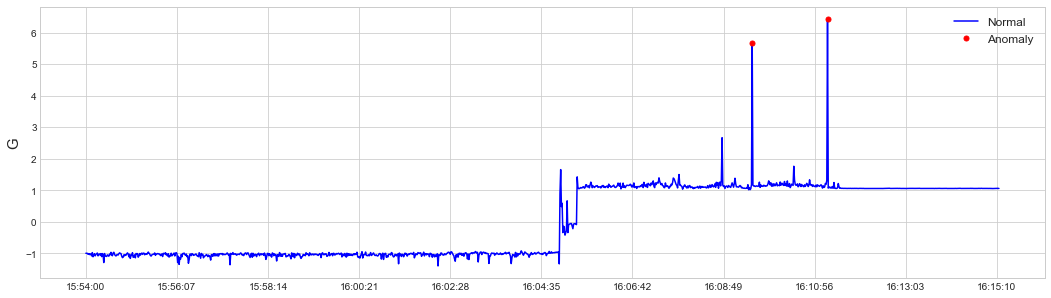

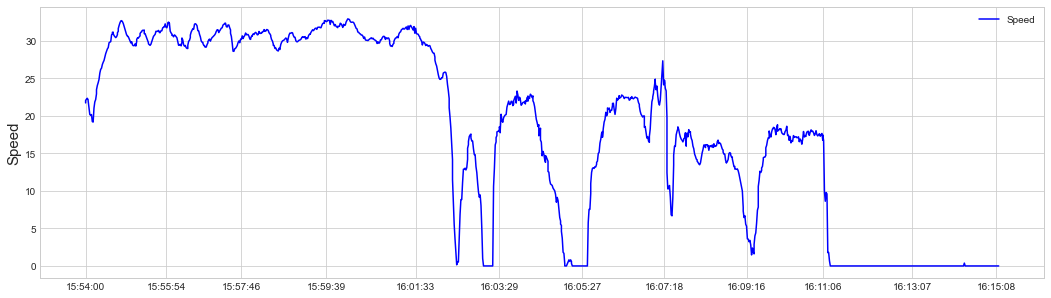

None
The journey Id is: 348D851E-171F-47E6-85DB-D0272515CCBA.csv
possible accident time for journey: 6 []


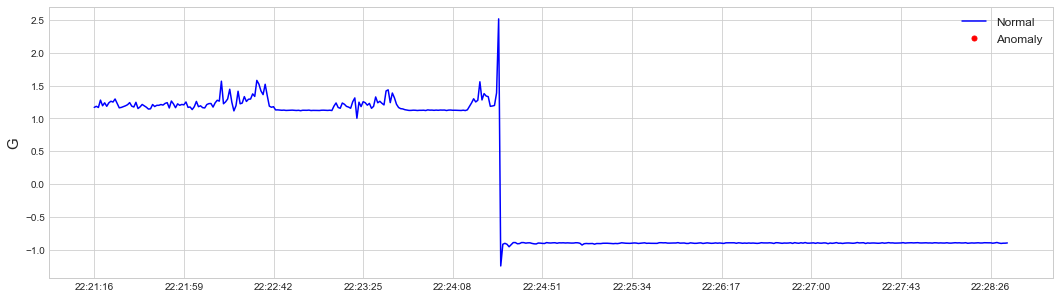

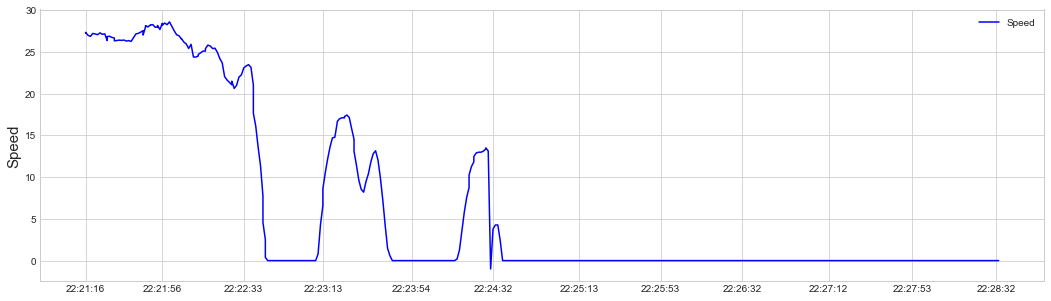

None
The journey Id is: 4475987E-0048-4D49-84A9-70E439C66B5B.csv
possible accident time for journey: 7 []


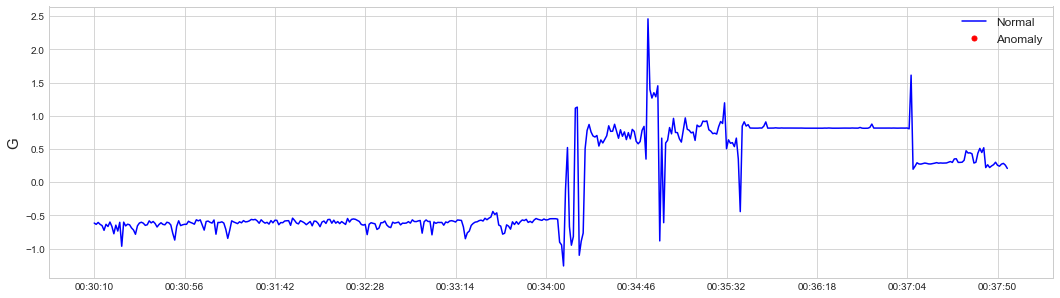

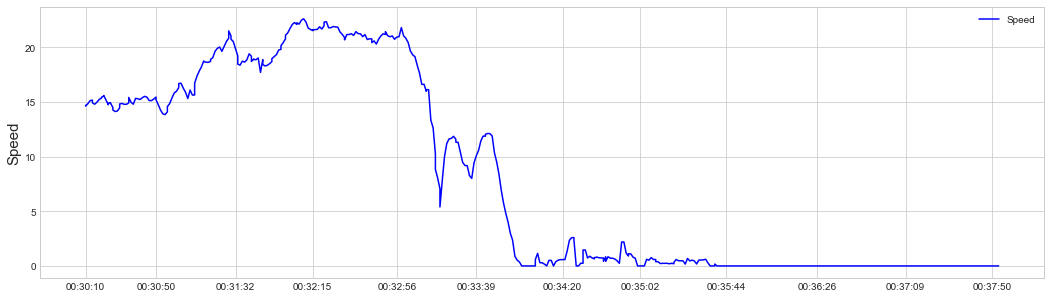

None
The journey Id is: 45F527C2-98FB-4ABF-B680-43EA726A0E7F.csv
possible accident time for journey: 8 ['10:38:24' '10:39:49' '10:40:09' '10:40:15' '10:40:42' '10:40:49'
 '10:40:50']


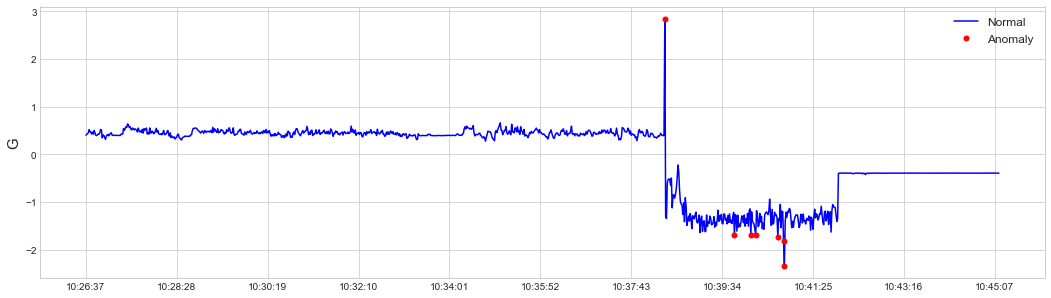

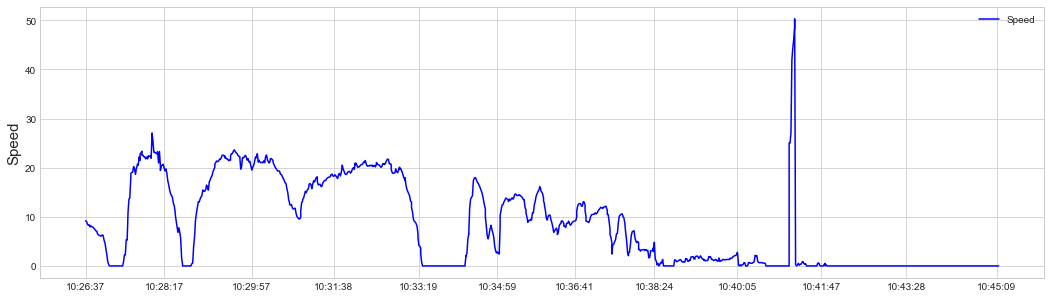

None
The journey Id is: 4D735D9B-15C6-48F2-A78E-BDFCBC523115.csv
possible accident time for journey: 9 ['21:13:00' '21:15:45' '21:15:46' '21:16:09' '21:21:08' '21:21:09'
 '21:21:32' '21:21:33' '21:21:36' '21:21:38' '21:21:39' '21:21:40'
 '21:21:43' '21:21:44' '21:21:45' '21:21:46' '21:21:47' '21:21:49'
 '21:21:50' '21:21:51' '21:21:52' '21:21:53' '21:21:54' '21:21:55'
 '21:21:56' '21:21:57' '21:21:58' '21:22:05' '21:22:06' '21:22:07'
 '21:22:08' '21:22:09' '21:22:10' '21:22:11' '21:22:12' '21:22:13'
 '21:22:14' '21:22:15' '21:22:16' '21:22:17' '21:22:28' '21:22:29'
 '21:22:30' '21:22:31' '21:22:32' '21:22:33' '21:22:34' '21:22:36'
 '21:22:37' '21:22:38' '21:22:39' '21:22:40' '21:22:41' '21:22:42'
 '21:22:43' '21:22:44' '21:22:45' '21:22:46' '21:22:47' '21:22:48'
 '21:22:49' '21:22:50' '21:22:51' '21:22:52' '21:22:53' '21:22:54'
 '21:22:55' '21:22:56' '21:22:57' '21:22:58' '21:22:59' '21:23:00'
 '21:23:01' '21:23:02' '21:23:03' '21:23:08' '21:23:09' '21:23:10'
 '21:23:11' '21:23:12' '21

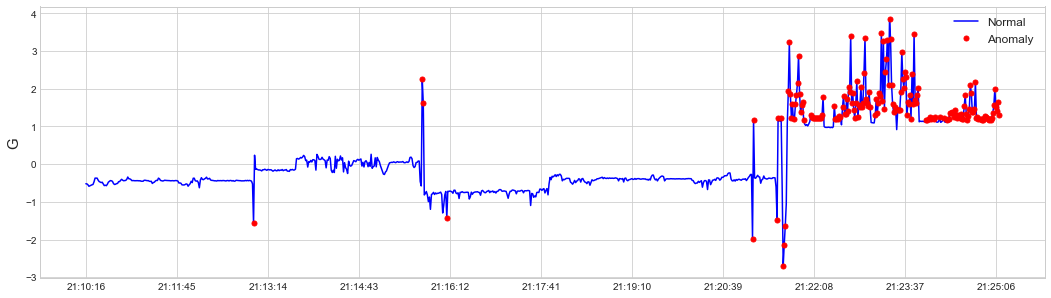

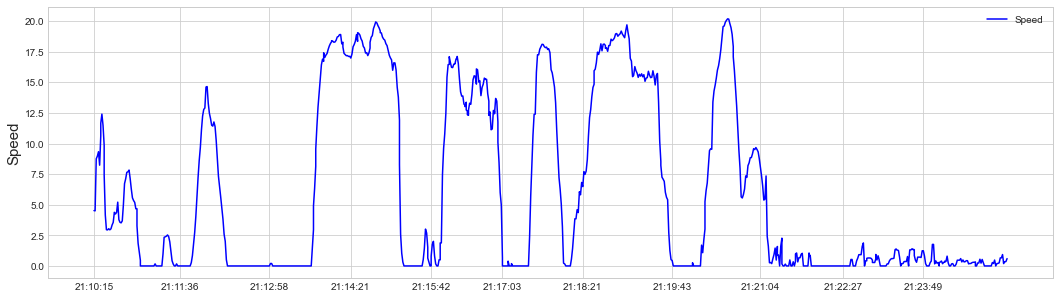

None
The journey Id is: 5F209F01-4235-47BE-ADEB-2A7877C95271.csv
possible accident time for journey: 10 ['20:22:48' '20:34:21' '20:34:24' '20:35:15' '20:35:20' '20:35:21'
 '20:35:41' '20:35:45' '20:36:08' '20:36:48' '20:36:49' '20:55:57'
 '20:56:00']


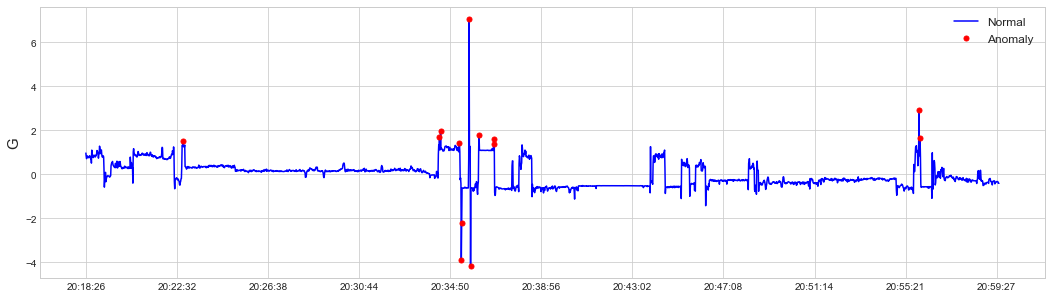

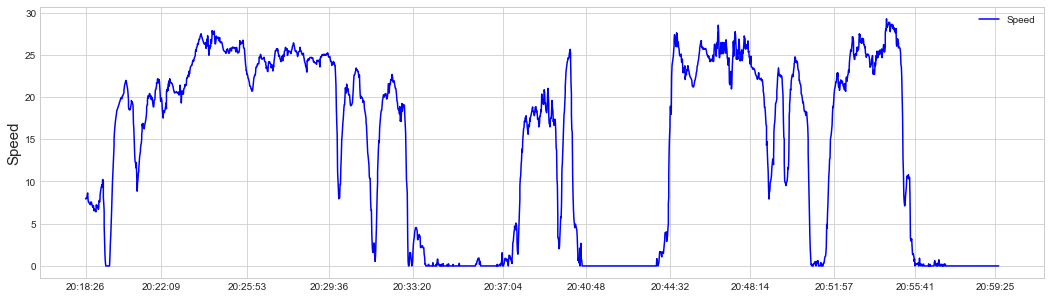

None
The journey Id is: 636C5BAE-D065-4B45-B985-8830B5D8973A.csv
possible accident time for journey: 11 ['20:32:12' '20:32:15' '20:33:28' '20:33:53' '20:33:54' '20:34:02'
 '20:35:59' '20:36:05' '20:36:09' '20:46:17' '20:46:44' '20:46:46'
 '20:46:47' '20:46:48' '20:46:49' '20:46:50' '20:46:53' '20:46:54'
 '20:46:55' '20:47:02' '20:47:04' '20:47:09' '20:47:10' '20:47:13'
 '20:47:14' '20:47:16' '20:47:17' '20:47:20' '20:47:21' '20:47:22'
 '20:47:23' '20:47:24' '20:47:25' '20:47:26' '20:47:27' '20:47:28'
 '20:47:30' '20:47:31' '20:47:32' '20:47:33' '20:47:34' '20:47:35'
 '20:47:36' '20:47:37' '20:47:38' '20:47:39' '20:47:40' '20:47:41'
 '20:47:42' '20:47:43' '20:47:44' '20:47:45' '20:47:46' '20:47:47'
 '20:47:48' '20:47:49' '20:47:50' '20:47:51' '20:47:52' '20:47:53'
 '20:47:54' '20:47:55' '20:47:56' '20:47:57' '20:47:58' '20:47:59'
 '20:48:00' '20:48:01' '20:48:02' '20:48:03' '20:48:04' '20:48:05'
 '20:48:06' '20:48:07' '20:48:08' '20:48:09' '20:48:10' '20:48:11'
 '20:48:12' '20:48:13' '2

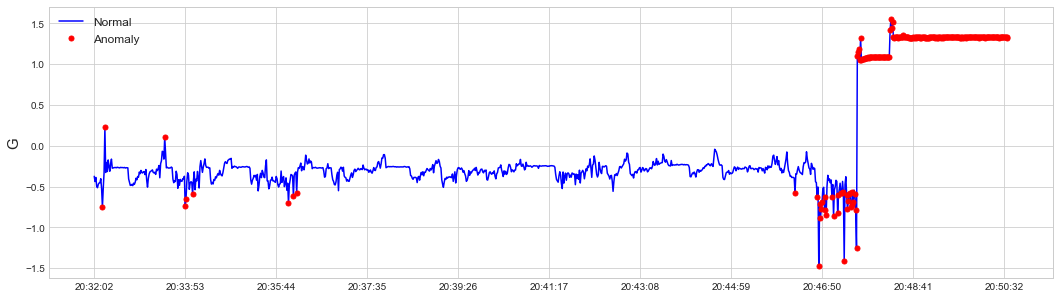

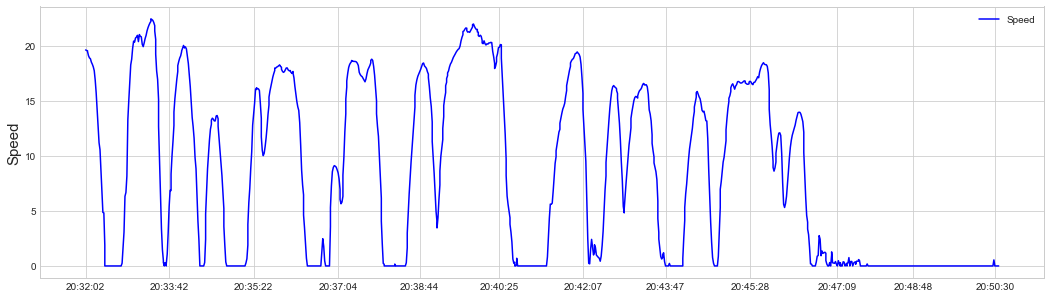

None
The journey Id is: 68E6E44C-2A24-42B8-9314-C6A9FFC5EC8D.csv
possible accident time for journey: 12 []


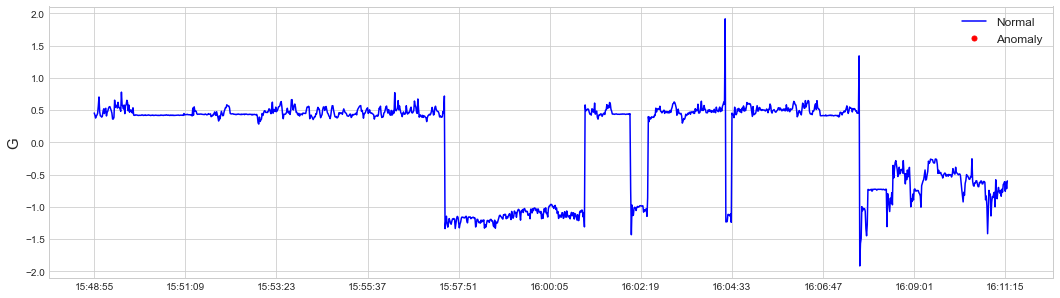

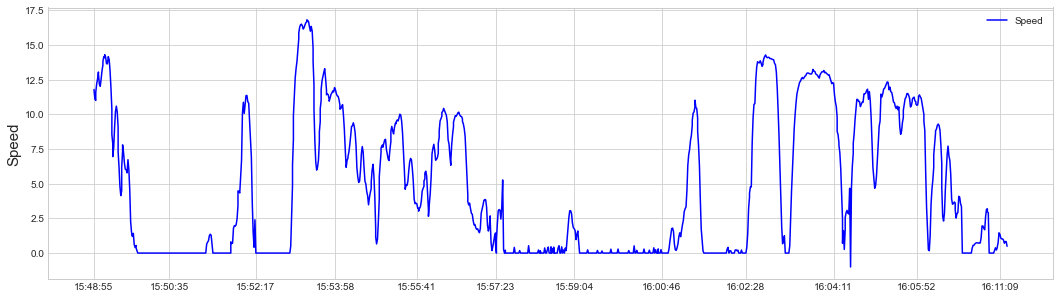

None
The journey Id is: 78C58FEE-A616-436F-8709-6D755FACF525.csv
possible accident time for journey: 13 ['13:01:39' '13:01:45' '13:01:46' '13:01:51' '13:01:52' '13:02:42'
 '13:03:28' '13:04:39' '13:04:49' '13:05:29']


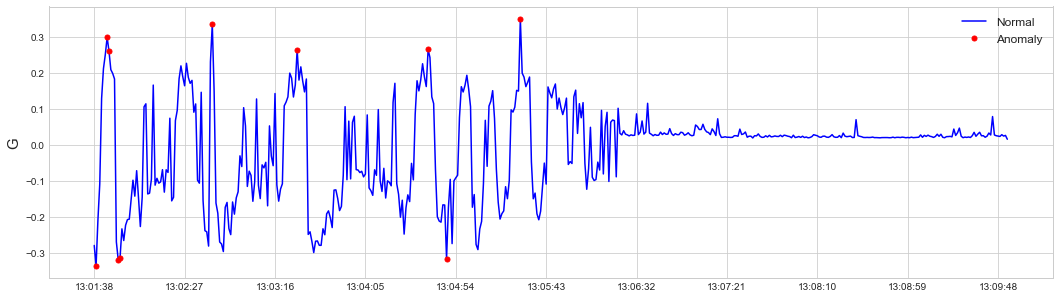

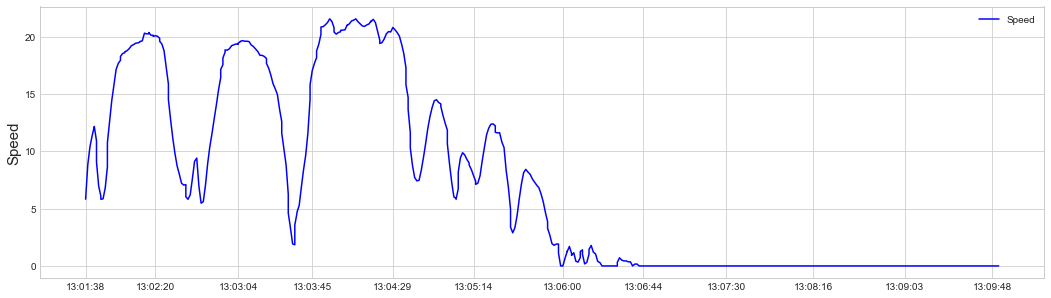

None
The journey Id is: 7D4D575C-26BD-4CD3-90FD-D97FBD433947.csv
possible accident time for journey: 14 ['22:24:49' '22:28:54']


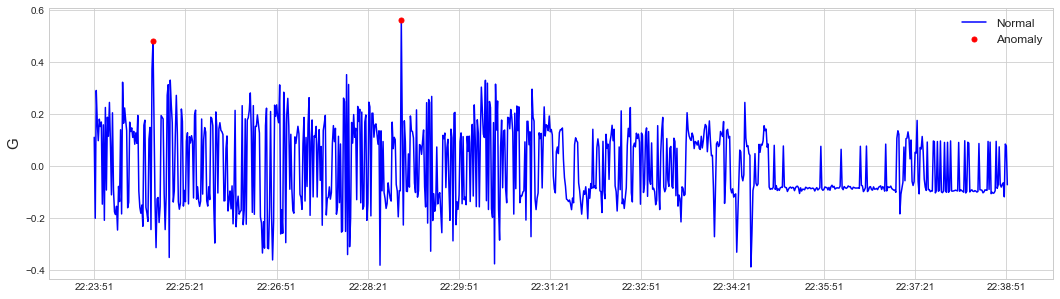

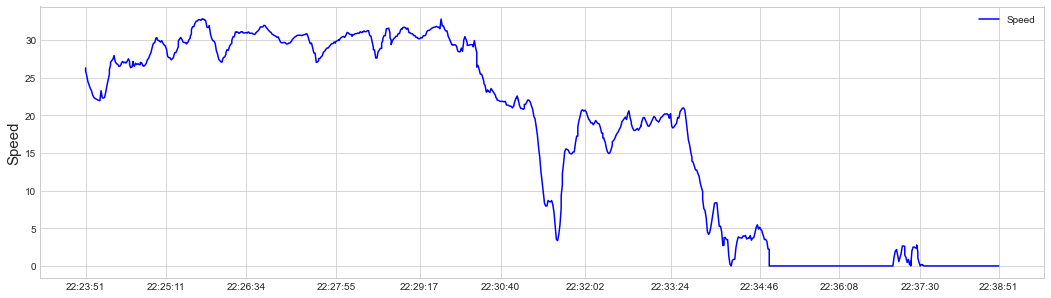

None
The journey Id is: 844709EE-F9AA-4B66-B682-860339FCBC1C.csv
possible accident time for journey: 15 ['21:09:59' '21:10:00' '21:10:34' '21:28:39' '21:29:58' '21:30:53'
 '21:30:55' '21:33:12' '21:37:16' '21:41:08']


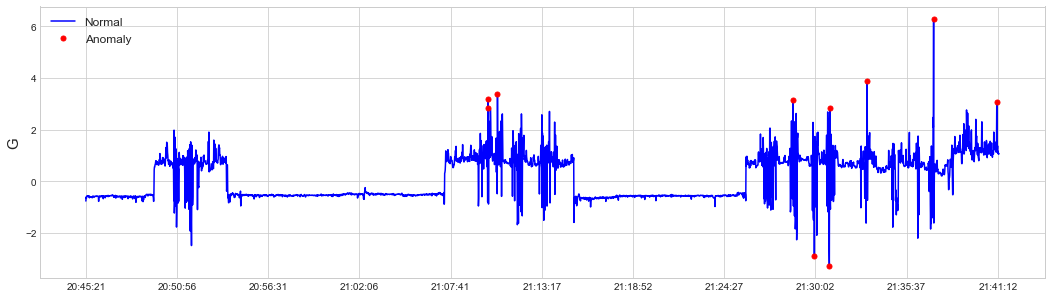

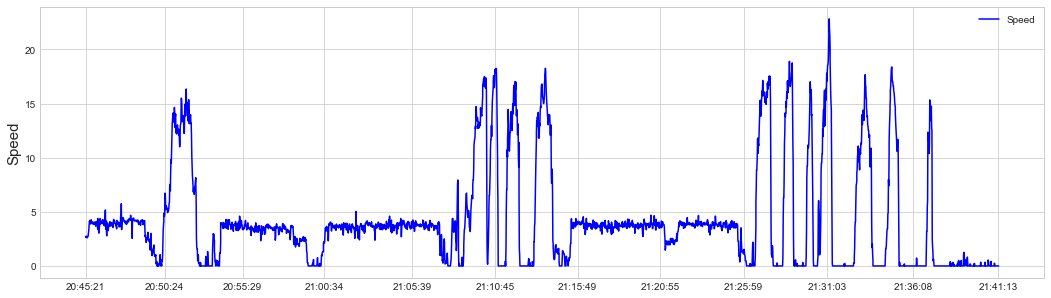

None
The journey Id is: 9EB59633-AD54-47F0-AC5F-61F3A183DB30.csv
possible accident time for journey: 16 ['16:42:02' '16:43:03' '16:43:04' '16:43:05' '16:43:06' '16:43:07'
 '16:43:08' '16:43:10' '16:43:11' '16:43:13' '16:43:16' '16:43:18'
 '16:43:20' '16:43:23' '16:43:26' '16:43:27' '16:43:36' '16:43:52'
 '16:43:55' '16:43:57' '16:43:59' '16:44:31' '16:44:37' '16:44:58'
 '16:44:59' '16:45:05' '16:45:06' '16:45:07' '16:45:08' '16:47:56'
 '16:48:26' '16:48:29' '16:49:10' '16:49:11' '16:49:12' '16:49:13'
 '16:49:14' '16:49:15' '16:49:16' '16:49:17' '16:49:18' '16:49:19'
 '16:49:20' '16:49:21']


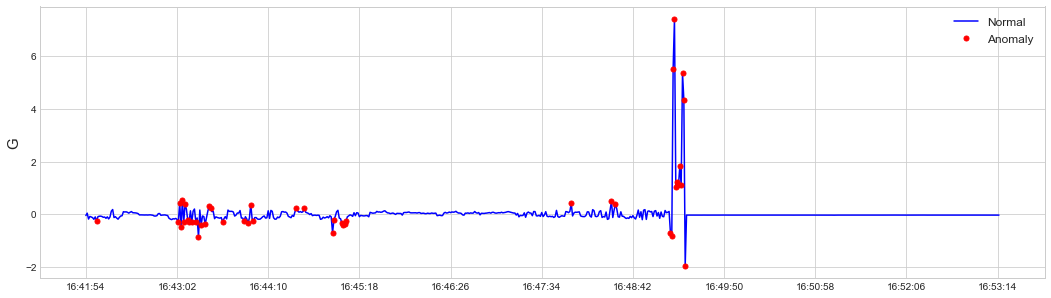

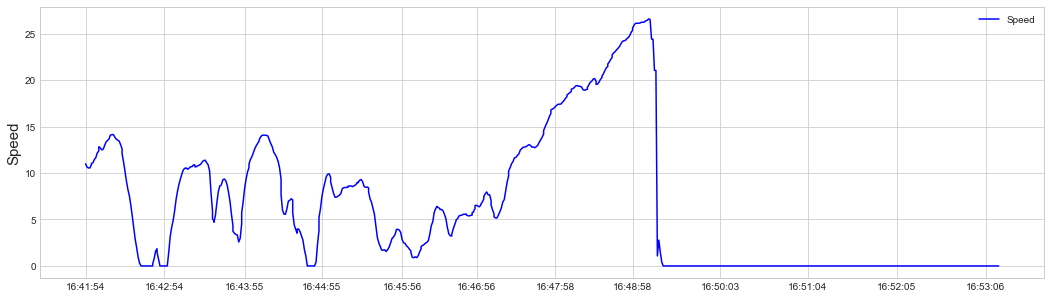

None
The journey Id is: b0b25b30-c3b3-48a4-9e20-810363501c64.csv
possible accident time for journey: 17 []


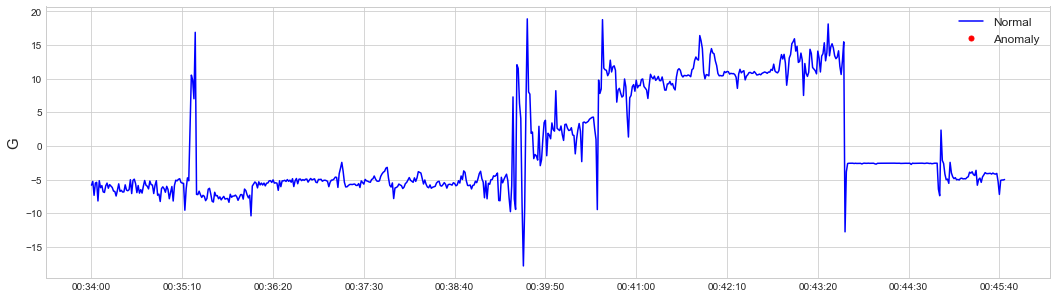

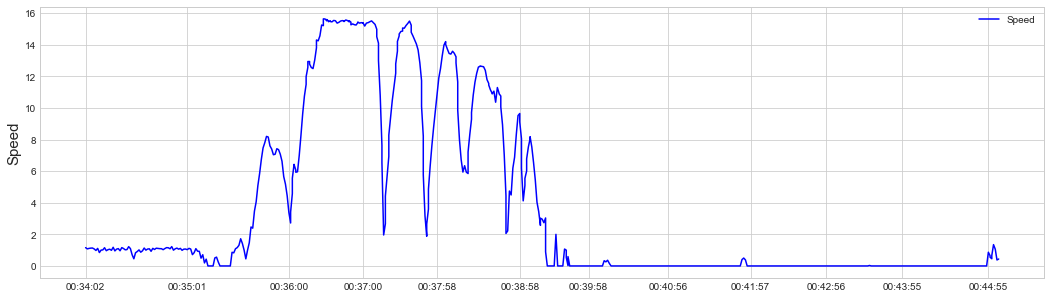

None
The journey Id is: B194DCB3-8906-47E7-963D-32985B5ABD51.csv
possible accident time for journey: 18 ['20:36:43' '20:36:44' '20:36:45' '20:36:46' '20:36:47' '20:36:48'
 '20:36:49' '20:36:50' '20:36:51' '20:36:52' '20:36:53' '20:36:54'
 '20:36:55' '20:36:56' '20:36:57' '20:36:58' '20:36:59' '20:37:00'
 '20:37:01' '20:37:02' '20:37:03' '20:37:04' '20:37:05' '20:37:06'
 '20:37:07' '20:37:08' '20:37:09' '20:37:10' '20:37:11' '20:37:12'
 '20:37:13' '20:37:14' '20:37:15' '20:37:16' '20:37:17' '20:37:18'
 '20:37:19' '20:37:20' '20:37:22' '20:37:23' '20:37:24' '20:37:25'
 '20:37:26' '20:37:27' '20:37:28' '20:37:29' '20:37:30' '20:37:31'
 '20:37:32' '20:37:33' '20:37:34' '20:37:35' '20:37:36' '20:37:37'
 '20:37:38' '20:37:39' '20:37:40' '20:37:41' '20:37:42' '20:37:43'
 '20:37:44' '20:37:45' '20:37:46' '20:37:47' '20:37:48' '20:37:49'
 '20:37:50' '20:37:51' '20:37:52' '20:37:53' '20:37:54' '20:37:55'
 '20:37:56' '20:38:07' '20:38:08' '20:38:10' '20:38:11' '20:38:12'
 '20:38:13' '20:38:16' '2

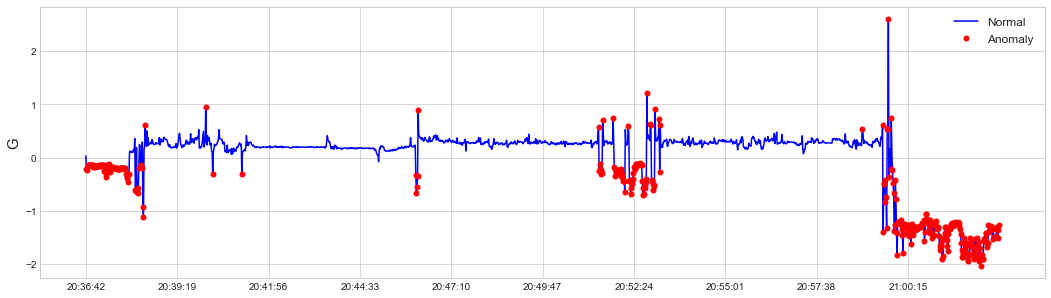

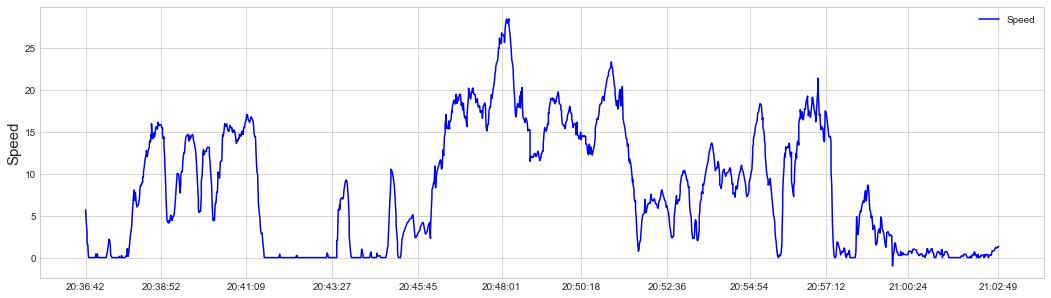

None
The journey Id is: BBDE8492-57F2-4697-87B7-BEB6100EBAE1.csv
possible accident time for journey: 19 ['00:36:12' '00:36:13' '00:36:14' '00:36:15' '00:36:16' '00:36:17'
 '00:36:18' '00:36:20' '00:36:22' '00:36:23' '00:36:24' '00:36:25'
 '00:38:35' '00:42:19' '00:42:20' '00:42:21' '00:42:22' '00:42:23'
 '00:42:24' '00:42:25' '00:42:27' '00:42:28' '00:42:29' '00:42:30'
 '00:42:31' '00:42:32' '00:42:33' '00:42:34' '00:42:35' '00:42:36'
 '00:42:37' '00:42:38' '00:42:39' '00:42:40' '00:42:41' '00:42:44'
 '00:42:46' '00:42:47' '00:42:48' '00:42:49' '00:42:50' '00:42:51'
 '00:42:52' '00:42:53' '00:42:54' '00:42:55' '00:42:56' '00:42:57'
 '00:42:58' '00:42:59' '00:43:00' '00:43:11' '00:43:12' '00:43:16'
 '00:43:23' '00:43:24' '00:43:27' '00:43:29' '00:43:31' '00:43:32'
 '00:43:33' '00:43:34' '00:43:35' '00:43:36' '00:43:37' '00:43:38'
 '00:43:39' '00:43:40' '00:43:41' '00:43:42' '00:43:43' '00:43:44'
 '00:43:45' '00:43:46' '00:43:47' '00:43:48' '00:43:49' '00:43:50'
 '00:43:51' '00:43:52' '0

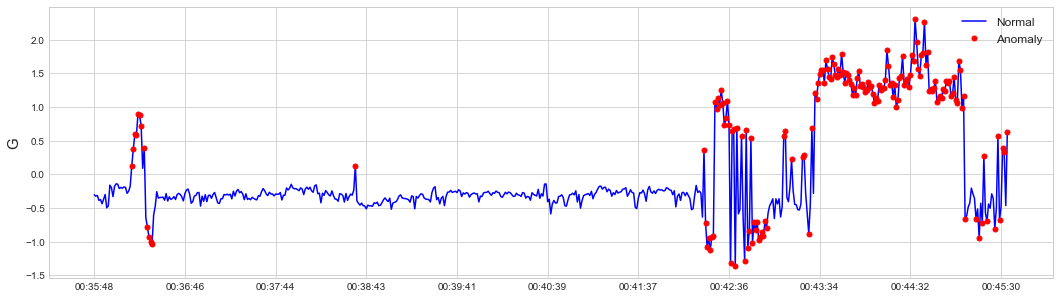

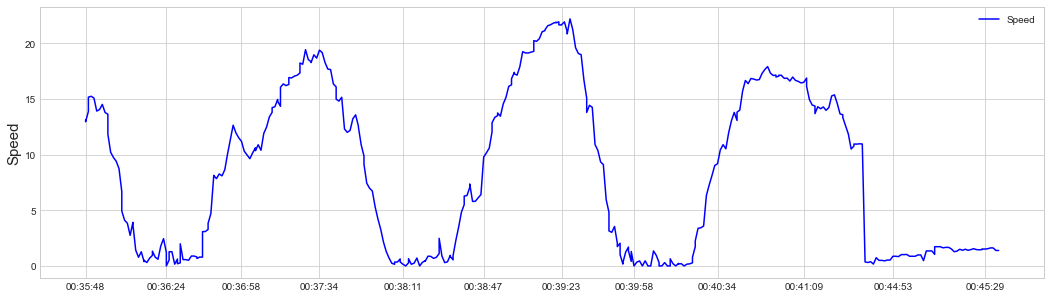

None
The journey Id is: E66D6050-11EA-4816-A096-0B0E88234BFD.csv
possible accident time for journey: 20 ['18:25:12' '18:25:57' '18:26:16' '18:27:10' '18:27:11' '18:27:12'
 '18:27:13' '18:27:14' '18:27:16' '18:27:17' '18:27:18' '18:27:22'
 '18:27:23' '18:27:24' '18:27:25' '18:27:27' '18:27:29' '18:27:30'
 '18:27:33' '18:27:34' '18:27:36' '18:27:38' '18:27:39' '18:27:41'
 '18:27:42' '18:27:43' '18:27:44' '18:27:45' '18:27:47' '18:27:49'
 '18:27:50' '18:27:51' '18:27:52' '18:27:53' '18:27:54' '18:27:56'
 '18:27:57' '18:27:58' '18:27:59' '18:28:00' '18:28:01' '18:28:03'
 '18:28:06' '18:28:07' '18:28:08' '18:28:09' '18:28:11' '18:28:12'
 '18:28:13' '18:28:15' '18:28:16' '18:28:17' '18:28:18' '18:28:20'
 '18:28:21' '18:28:23' '18:28:26' '18:28:27' '18:28:29' '18:28:30'
 '18:28:31' '18:28:32' '18:28:33' '18:28:34' '18:28:35' '18:28:36'
 '18:28:37' '18:28:38' '18:28:39' '18:28:40' '18:28:41' '18:28:42'
 '18:28:44' '18:28:45' '18:28:46' '18:28:47' '18:28:48' '18:28:49'
 '18:28:50' '18:28:53' '1

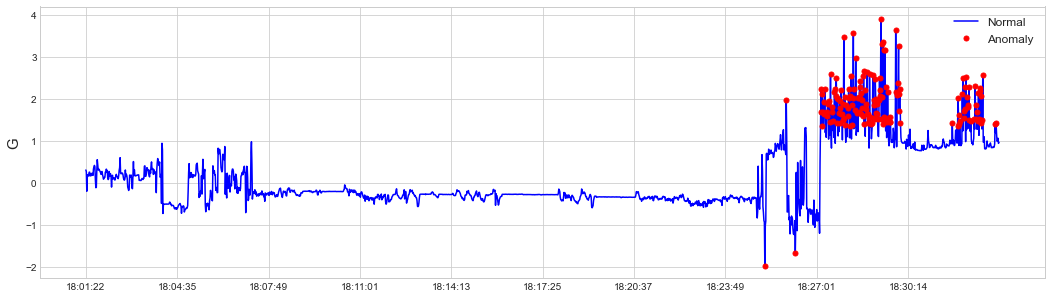

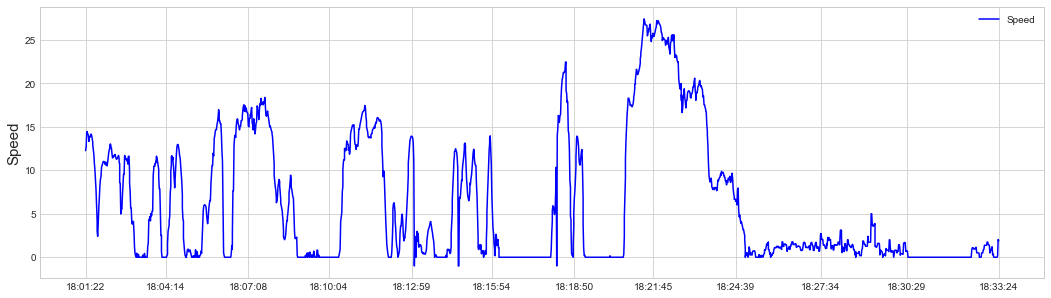

None
The journey Id is: E91DC5BB-A924-49B0-B984-BCEEF656FC5A.csv
possible accident time for journey: 21 ['19:28:41']


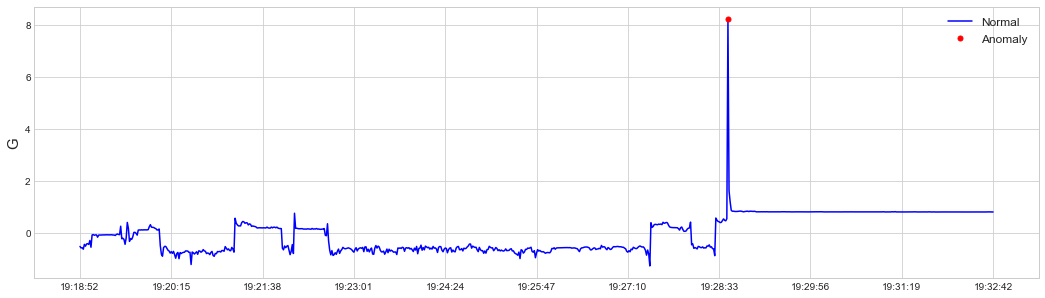

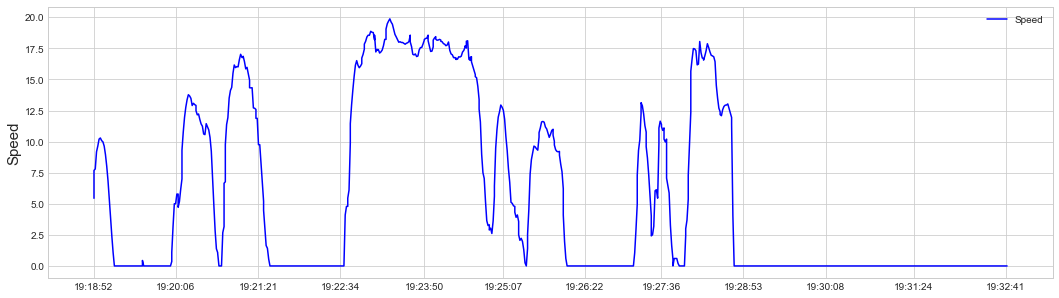

None
The journey Id is: EC16DDC1-4AFF-4A78-AF04-E22530A77E11.csv
possible accident time for journey: 22 []


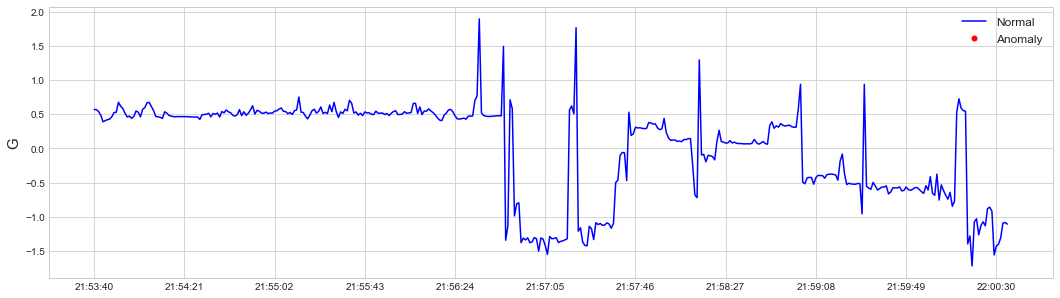

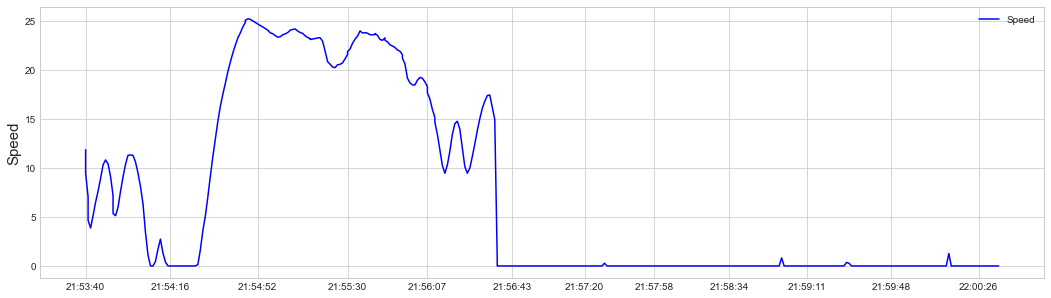

None
The journey Id is: EF0AFFAA-FC7C-4EF9-B2C4-BD437CD78E01.csv
possible accident time for journey: 23 ['12:32:29' '12:33:08' '12:33:17' '12:35:40']


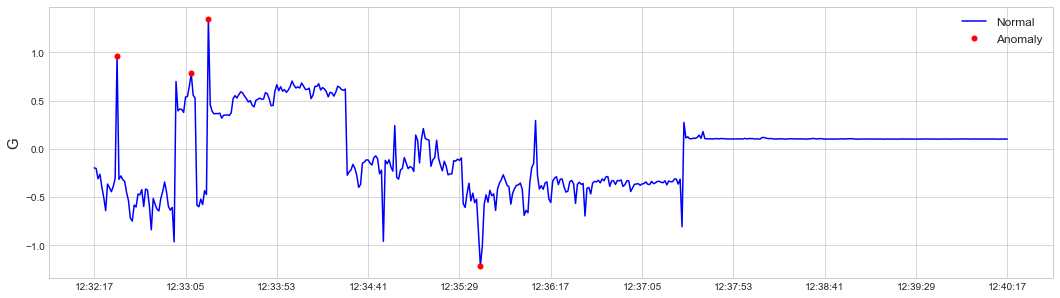

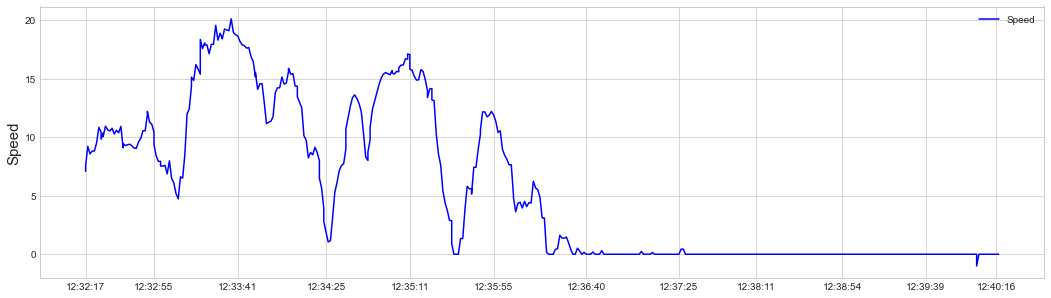

None
The journey Id is: FC3DC207-9459-4CBE-8AB5-0E0AC77D5FEC.csv
possible accident time for journey: 24 ['22:03:30' '22:10:04' '22:10:05' '22:10:08' '22:10:13' '22:10:26'
 '22:10:27' '22:12:57' '22:13:05' '22:13:21']


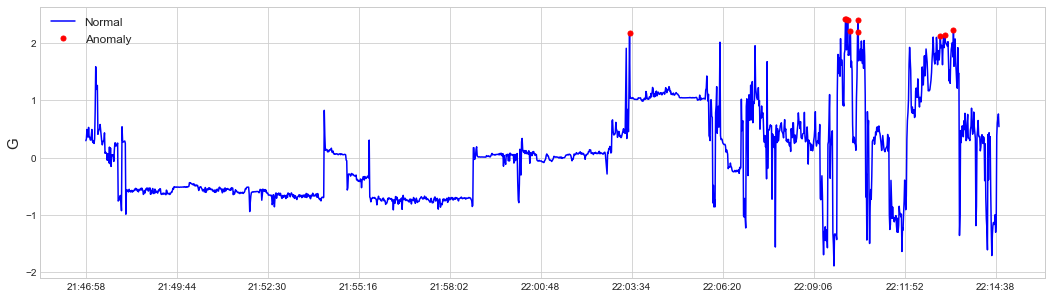

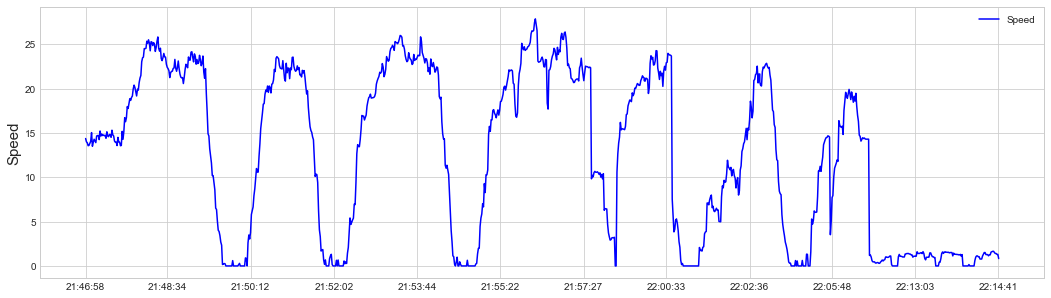

None


In [1270]:
#anomalies for each journey
for i in d.keys():
    x = Journey(i)
    print('The journey Id is:', file_name_dict[i])
    print(x.anomaly())
